This is for Chapter 14 from Statistical Rethinking. A public repo using `pmyc3` has been created [here](https://github.com/pymc-devs/resources/tree/master/Rethinking_2) that also uses Python.

In [2]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import scipy.stats as stats
import seaborn as sns
from scipy.special import expit as logistic
from scipy.special import logit
from scipy.optimize import curve_fit
import daft
from causalgraphicalmodels import CausalGraphicalModel
from theano import tensor as tt

In [3]:
%load_ext nb_black
%config InlineBackend.figure_format = 'retina'
%load_ext watermark
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")
az.rcParams["stats.hdi_prob"] = 0.89  # sets default credible interval used by arviz

<IPython.core.display.Javascript object>

In [4]:
sns.set_context("talk")

<IPython.core.display.Javascript object>

In [5]:
def standardize(x):
    x = (x - np.mean(x)) / np.std(x)
    return x

<IPython.core.display.Javascript object>

# Easy problems

## 14H1

**Original equation**

$$y_i \sim \text{Normal}(\mu_i, \sigma)$$

$$\mu_i = \alpha_{\text{GROUP}[i]} + \beta x_i \tag{note no "GROUP" for the slope}$$

$$\alpha_{\text{GROUP}[i]} \sim \text{Normal}(\alpha, \sigma_{\alpha}) \tag{varying intercept, using an adaptive prior}$$

$$\beta \sim \text{Normal}(0, 1) \tag{slope uses only a regularizing prior!}$$

Hyperpriors follow:

$$\alpha \sim \text{Normal}(0, 10) $$

$$\sigma \sim \text{Exponential}(1) $$

$$\sigma_{\alpha} \sim \text{Exponential}(1) $$

In the varying slopes model, instead of having separate lines for the priors for intercepts and slopes, we put them in the same multivariate normal covariance matrix. This allows information sharing between slopes and intercepts. This works through adaptive regularization of individual group intercepts, their slopes, and the correlation among them. 

**Equation with varying slopes on the predictor x**

$$y_i \sim \text{Normal}(\mu_i, \sigma)$$

$$\mu_i = \alpha_{\text{GROUP}[i]} + \beta_{\text{GROUP}[i]} x_i \tag{"GROUP" added for the slope}$$

$$\begin{bmatrix}\alpha_{\text{GROUP}} \\ \beta_{\text{GROUP}} \end{bmatrix} \text { ~ MVNormal } \left( \begin{bmatrix}\alpha \\ \beta \end{bmatrix} , \text{S} \right)  \tag{adaptive prior as joint population of slopes and intercepts} $$

The covariance matrix **S** is defined here. (Note: The top left of each array is isn't showing up correctly. It should be \(\sigma_{\alpha}\).)

$$ \text{S} = \left(\begin{array} \sigma_{\alpha} & 0 \\ 0 & \sigma_{\beta} \end{array}\right)  \text{R} \left(\begin{array} \sigma_{\alpha} & 0 \\ 0 & \sigma_{\beta} \end{array}\right) \tag{construct covariance matrix} $$

R is a correlation matrix with a hyperprior defined below.


Hyperpriors down below:

$$\alpha \sim \text{Normal}(0, 10) $$

$$\beta \sim \text{Normal}(0, 1)\tag{added hyperprior}$$

$$\sigma \sim \text{Exponential}(1) $$

$$\sigma_{\alpha} \sim \text{Exponential}(1) $$

$$\sigma_{\beta} \sim \text{Exponential}(1) $$

$$R \sim \text{LKJcorr}(2) \tag{prior for correlation matrix}$$ 

(Note: The top left of this array is isn't showing up correctly. It should be 1.)

$$ \text{R} = \left(\begin{array} 1 & \rho \\ \rho & 1 \end{array}\right)  \tag{construct covariance matrix} $$

The LKJcorr is a weakly informative prior on \(\rho\) that is skeptical of extreme correlations near -1 or 1.

## 14E2

Think up a context in which varying intercepts will be positively correlated with varying
slopes. Provide a mechanistic explanation for the correlation.

# Medium problems

##  14M2

Fit this multilevel model to the simulated café data:

$$ W_i \sim \text{Normal}(\mu_i, \sigma) $$
$$ \mu_i = \alpha_{\text{CAFE}[i]} + \beta_{\text{CAFE}[i]}A_i $$

$$ \alpha_{\text{CAFE}} \sim \text{Normal}(\alpha, \sigma_{\alpha}) $$
$$ \beta_{\text{CAFE}} \sim \text{Normal}(\beta, \sigma_{\beta}) $$
$$ \alpha \sim \text{Normal}(0, 10) $$
$$ \beta \sim \text{Normal}(0, 10) $$
$$ \sigma, \sigma_{\alpha}, \sigma_{\beta} ∼ \text{Exponential}(1) $$

### Generate simulated data (from book and repo)

In [86]:
# Code from 14.1 - 14.9 in one block

# 14.1
a = 3.5  # average morning wait time
b = -1.0  # average difference afternoon wait time
sigma_a = 1.0  # std dev in intercepts
sigma_b = 0.5  # std dev in slopes
rho = -0.7  # correlation between intercepts and slopes

# 14.2
Mu = [a, b]

# 14.3
cov_ab = sigma_a * sigma_b * rho
Sigma = np.array([[sigma_a ** 2, cov_ab], [cov_ab, sigma_b ** 2]])
print("14.3 Sigma: ", Sigma)

# 14.4 (R)
# 14.5
sigmas = [sigma_a, sigma_b]
Rho = np.matrix([[1, rho], [rho, 1]])

Sigma = np.diag(sigmas) * Rho * np.diag(sigmas)
print("14.5 Sigma: ", Sigma)

# 14.6, 14.7, 14.8
N_cafes = 20
vary_effects = np.random.multivariate_normal(mean=Mu, cov=Sigma, size=N_cafes)
a_cafe = vary_effects[:, 0]
b_cafe = vary_effects[:, 1]


# 14.9
from matplotlib.patches import Ellipse, transforms

def Gauss2d(mu, cov, ci, ax=None):
    """Copied from statsmodel"""

    if ax is None:
        _, ax = plt.subplots(figsize=(6, 6))

    v_, w = np.linalg.eigh(cov)
    u = w[0] / np.linalg.norm(w[0])
    angle = np.arctan(u[1] / u[0])
    angle = 180 * angle / np.pi  # convert to degrees

    for level in ci:
        v = 2 * np.sqrt(v_ * stats.chi2.ppf(level, 2))  # get size corresponding to level
        ell = Ellipse(
            mu[:2],
            v[0],
            v[1],
            180 + angle,
            facecolor="None",
            edgecolor="k",
            alpha=(1 - level) * 0.5,
            lw=1.5,
        )
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.5)
        ax.add_artist(ell)

    return ax


14.3 Sigma:  [[ 1.   -0.35]
 [-0.35  0.25]]
14.5 Sigma:  [[ 1.   -0.35]
 [-0.35  0.25]]


<IPython.core.display.Javascript object>

In [6]:
N_visits = 10
afternoon = np.tile([0, 1], N_visits * N_cafes // 2)  # wrap with int() to suppress warnings
cafe_id = np.repeat(np.arange(0, N_cafes), N_visits)  # 1-20 (minus 1 for python indexing)

mu = a_cafe[cafe_id] + b_cafe[cafe_id] * afternoon
sigma = 0.5  # std dev within cafes

wait = np.random.normal(loc=mu, scale=sigma, size=N_visits * N_cafes)
d = pd.DataFrame(dict(cafe=cafe_id, afternoon=afternoon, wait=wait))
d

,cafe,afternoon,wait
0,0,0,2.316058
1,0,1,3.076007
2,0,0,2.747903
3,0,1,1.477530
4,0,0,3.343718
...,...,...,...
195,19,1,4.302526
196,19,0,5.043274
197,19,1,3.786776
198,19,0,3.794153


### Book example, model 14.1

In [9]:
# Code 14.12
cafe_idx = d["cafe"].values
with pm.Model() as m14_1:
    # LKJCholeskyCov is more efficient than LKJCorr
    # PyMC >= 3.9 extracts the stds and matrix of correlations automatically for us
    chol, Rho_, sigma_cafe = pm.LKJCholeskyCov(
        "chol_cov", n=2, eta=2, sd_dist=pm.Exponential.dist(1.0), compute_corr=True
    )

    a = pm.Normal("a", mu=5.0, sd=2.0)  # prior for average intercept
    b = pm.Normal("b", mu=-1.0, sd=0.5)  # prior for average slope
    ab_cafe = pm.MvNormal(
        "ab_cafe", mu=tt.stack([a, b]), chol=chol, shape=(N_cafes, 2)
    )  # population of varying effects
    # shape needs to be (N_cafes, 2) because we're getting back both a and b for each cafe

    mu = ab_cafe[cafe_idx, 0] + ab_cafe[cafe_idx, 1] * d["afternoon"].values  # linear model
    sigma_within = pm.Exponential("sigma_within", 1.0)  # prior stddev within cafes

    wait = pm.Normal("wait", mu=mu, sigma=sigma_within, observed=d["wait"].values)  # likelihood

    trace_14_1 = pm.sample(4000, tune=4000, target_accept=0.9)
    idata_14_1 = az.from_pymc3(
        trace_14_1,
        dims={"ab_cafe": ["cafe_nbr", "var_effect"]},
        coords={
            "chol_cov_stds_dim_0": ["intercepts", "slopes"],
            "var_effect": ["intercepts", "slopes"],
        },
    )
post = idata_14_1.posterior = idata_14_1.posterior.rename_vars(
    {"chol_cov_corr": "Rho", "chol_cov_stds": "sigma_cafe"}
)

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/pymc3/sampling.py:465: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_within, ab_cafe, b, a, chol_cov]


Sampling 4 chains for 4_000 tune and 4_000 draw iterations (16_000 + 16_000 draws total) took 198 seconds.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.


### Problem

In [82]:
az.summary(idata_14_1, var_names=["~ab_cafe", "~chol_cov"], round_to=2)

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/stats/diagnostics.py:642: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,3.74,0.24,3.35,4.10,0.0,0.0,15746.24,15702.09,15817.50,11240.54,1.0
b,-1.05,0.13,-1.26,-0.85,0.0,0.0,14245.34,14174.96,14245.76,11545.86,1.0
sigma_cafe[0],1.05,0.17,0.79,1.30,0.0,0.0,15033.59,14231.20,15933.55,12457.02,1.0
sigma_cafe[1],0.49,0.11,0.32,0.66,0.0,0.0,8080.51,8080.51,7737.98,8336.76,1.0
"Rho[0,0]",1.00,0.00,1.00,1.00,0.0,0.0,16000.00,16000.00,16000.00,16000.00,NaN
"Rho[0,1]",-0.78,0.12,-0.96,-0.62,0.0,0.0,9455.04,9035.95,7676.52,5497.68,1.0
"Rho[1,0]",-0.78,0.12,-0.96,-0.62,0.0,0.0,9455.04,9035.95,7676.52,5497.68,1.0
"Rho[1,1]",1.00,0.00,1.00,1.00,0.0,0.0,16000.00,16000.00,14928.09,15681.57,1.0
sigma_within,0.52,0.03,0.47,0.56,0.0,0.0,17348.49,17118.00,17593.57,11511.54,1.0


<IPython.core.display.Javascript object>

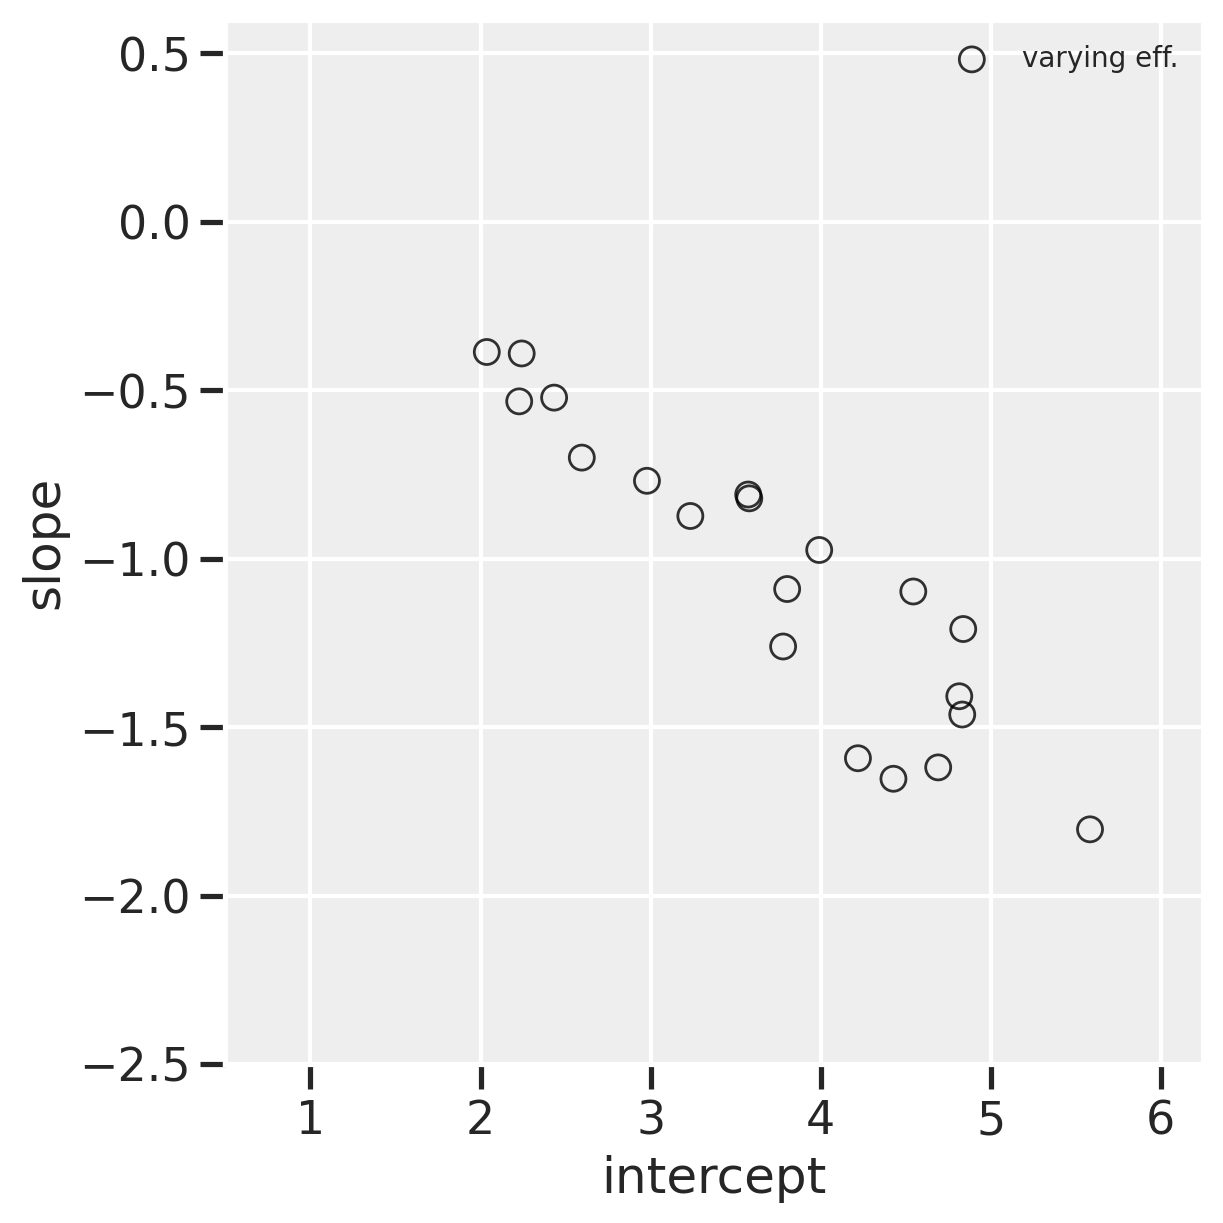

<IPython.core.display.Javascript object>

In [92]:
# compute unpooled estimates directly from data
a1b1 = d.groupby(["afternoon", "cafe"]).agg("mean").unstack(level=0).values
a1 = a1b1[:, 0]
b1 = a1b1[:, 1] - a1

# extract posterior means of partially pooled estimates
a2b2 = post["ab_cafe"].mean(dim=("chain", "draw"))
a2 = a2b2.sel(var_effect="intercepts")
b2 = a2b2.sel(var_effect="slopes")

# compute posterior mean bivariate Gaussian
ab = post[["a", "b"]].mean(dim=("chain", "draw"))
Mu_est = np.array([ab["a"], ab["b"]])
chol_model = pm.expand_packed_triangular(
    2, post["chol_cov"].mean(dim=("chain", "draw")), lower=True
).eval()
Sigma_est = np.dot(chol_model, chol_model.T)

# draw contours
_, ax = plt.subplots(1, 1, figsize=(6, 6))
# _ = Gauss2d(mu=Mu_est, cov=np.asarray(Sigma_est), ci=[0.1, 0.3, 0.5, 0.8, 0.99], ax=ax)

# plot both and connect with lines
#ax.scatter(a1, b1, label="unpooled", alpha=0.6)
ax.scatter(a2, b2, label="varying eff.", facecolors="none", edgecolors="k", lw=1, alpha=0.8)

#ax.plot([a1, a2], [b1, b2], "k-", alpha=0.5)
ax.set_xlabel("intercept")
ax.set_ylabel("slope")
ax.set_xlim(0.5, 6.25)
ax.set_ylim(-2.5, 0.6)
plt.legend(fontsize=10);

In [12]:
with pm.Model() as m14_2a:

    # hyperpriors
    a = pm.Normal("a", 0, 10)    # prior for average intercept
    b = pm.Normal("b", 0, 10)   # prior for average slope
    sigma = pm.Exponential("sigma", 1)
    sigma_a = pm.Exponential("sigma_a", 1)
    sigma_b = pm.Exponential("sigma_b", 1)

    # adaptive priors
    a_cafe = pm.Normal("a_cafe", sigma_a, shape=N_cafes)
    b_cafe = pm.Normal("b_cafe", sigma_b, shape=N_cafes)

    # linear model
    mu = a_cafe[d['cafe']] + b_cafe[d['cafe']] * d['afternoon']

    # likelihood
    W = pm.Normal("W", mu, sigma, observed = d['wait'])
    # trace for sampling
    trace_14_2a = pm.sample(4000, tune=4000, target_accept=0.9)

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/pymc3/sampling.py:465: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b_cafe, a_cafe, sigma_b, sigma_a, sigma, b, a]


Sampling 4 chains for 4_000 tune and 4_000 draw iterations (16_000 + 16_000 draws total) took 45 seconds.


In [14]:
az.compare({'MVprior' : trace_14_1, 'nonMVprior' : trace_14_2a}, ic='waic')

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/stats/stats.py:146: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(
/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/stats/stats.py:1466: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
MVprior,0,-167.499506,29.013802,0.000000,0.984968,8.702309,0.000000,True,log
nonMVprior,1,-171.961670,34.039125,4.462164,0.015032,8.404767,3.001449,True,log


### THM solution

The multivariate prior has a better fit because it leverages the correlations between the intercept and slope.

### Review of answer key

The answer key does not use WAIC, but it does plot the parameters of both models as a comparison. Let's do the same.

In [50]:
trace_14_1.varnames

['chol_cov_cholesky-cov-packed__',
 'a',
 'b',
 'ab_cafe',
 'sigma_within_log__',
 'chol_cov',
 'chol_cov_stds',
 'chol_cov_corr',
 'sigma_within']

In [32]:
trace_14_2a.varnames

['a',
 'b',
 'sigma_log__',
 'sigma_a_log__',
 'sigma_b_log__',
 'a_cafe',
 'b_cafe',
 'sigma',
 'sigma_a',
 'sigma_b']

In [51]:
print(trace_14_1.get_values(varname='ab_cafe').shape)

(16000, 20, 2)


In [64]:
a_cafe_means_m14_1 = list()
b_cafe_means_m14_1 = list()
for i in range(20):
    a_cafe_means_m14_1.append(trace_14_1.get_values(varname='ab_cafe')[:, i, 0].mean())
    b_cafe_means_m14_1.append(trace_14_1.get_values(varname='ab_cafe')[:, i, 1].mean())

In [47]:
print(trace_14_2a.get_values(varname='a_cafe').shape)
print(trace_14_2a.get_values(varname='b_cafe').shape)

(16000, 20)
(16000, 20)


In [65]:
a_cafe_means_m14_2a = list()
b_cafe_means_m14_2a = list()
for i in range(20):
    a_cafe_means_m14_2a.append(trace_14_2a.get_values(varname='a_cafe')[:, i].mean())
    b_cafe_means_m14_2a.append(trace_14_2a.get_values(varname='b_cafe')[:, i].mean())

In [96]:
# part of verification of figure
# plt.scatter(a2, a_cafe_means_m14_1)

<IPython.core.display.Javascript object>

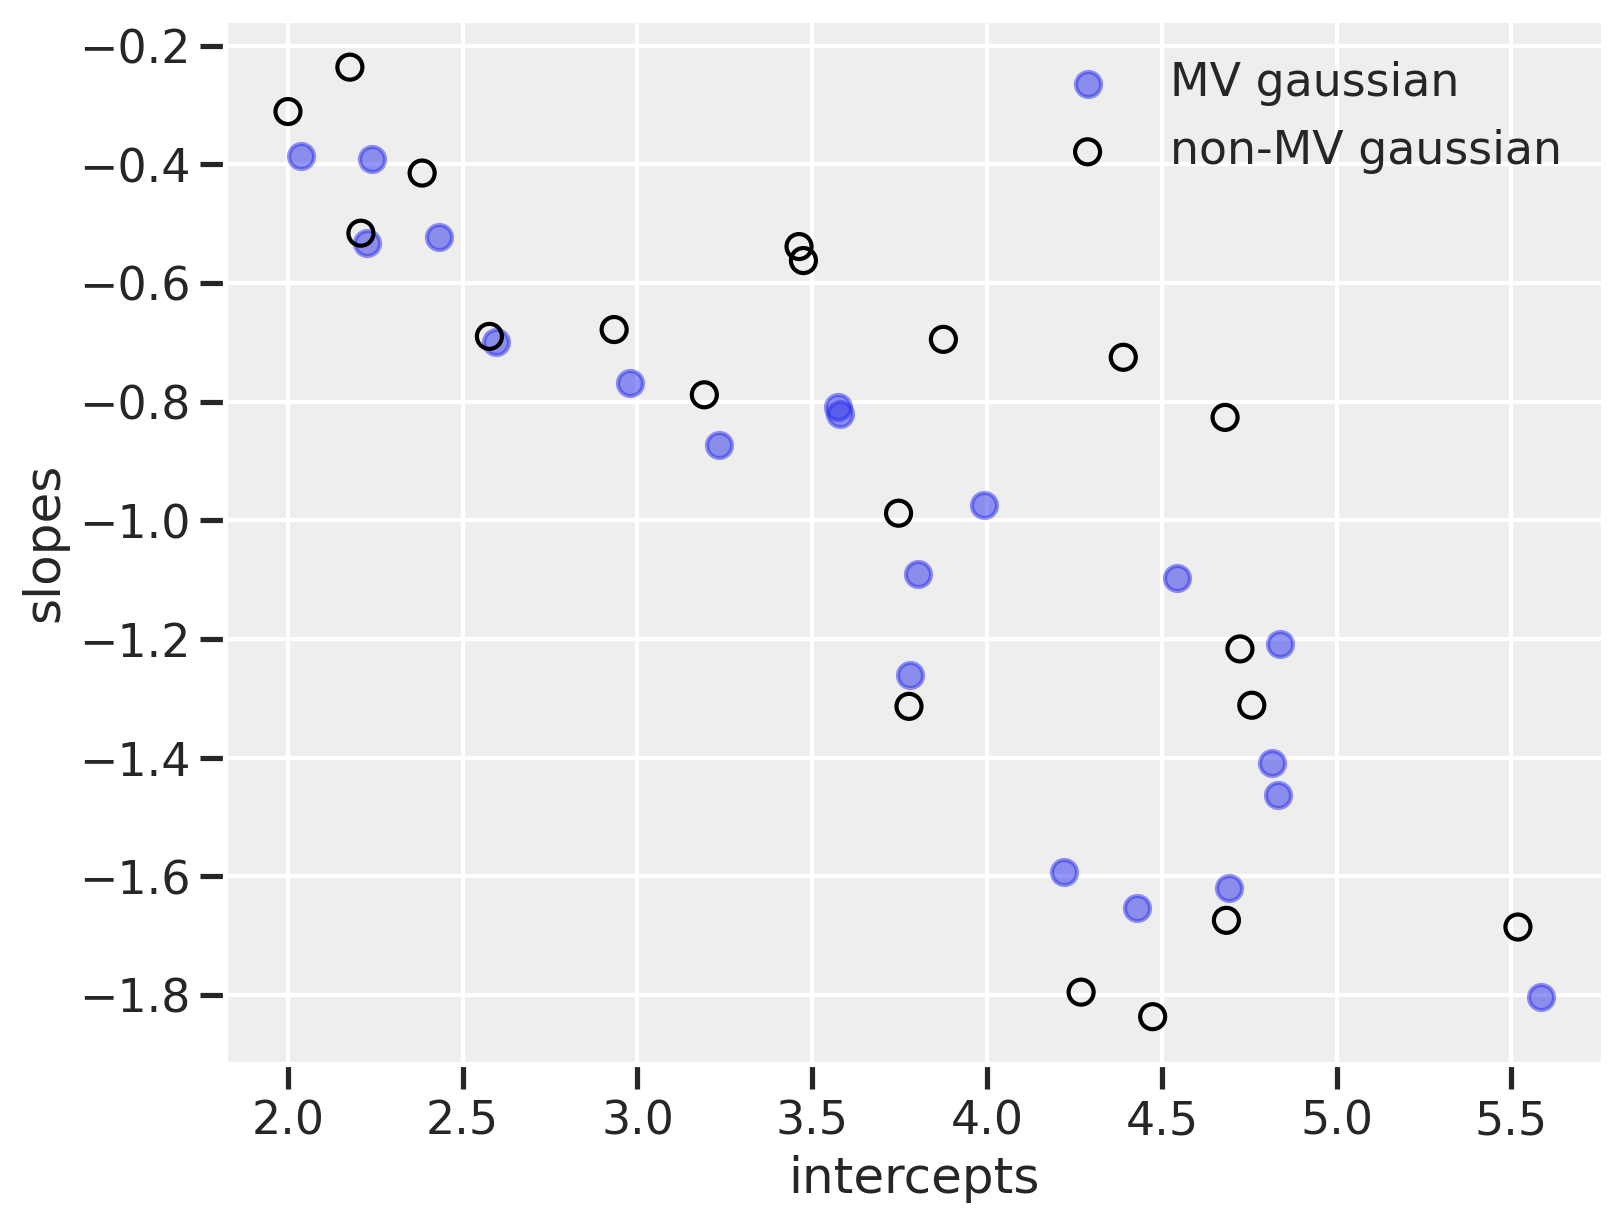

<IPython.core.display.Javascript object>

In [98]:
f, ax1 = plt.subplots(figsize=(8, 6))
ax1.scatter(a_cafe_means_m14_1, b_cafe_means_m14_1, alpha=0.5, label='MV gaussian')
ax1.scatter(a_cafe_means_m14_2a, b_cafe_means_m14_2a, facecolors='none', edgecolors='k', label='non-MV gaussian')
ax1.set(xlabel='intercepts', ylabel='slopes')
ax1.legend()
# ax1.set_xlim([1.75, 6.25])
# ax1.set_ylim([1.75, 6.25])

Note that the figure is different from answer key but I did some verification that what I did is likely right. (MV gaussian matches the book more than answer key.)

Overall, you see a pattern where the correlation is tighter in the MV Gaussian case (the points are clustered closer to a mean correlation line). While it's more apparent in the answer key example, the shift of points between the open circles (non-MV gaussian) and the filled circles (MV gaussian) is greater in the more extreme points. That is because that is where the information sharing has the biggest influence.

# Question 0 (13H1)

**The first question builds on this problem which is why I'm copying it here.**

In 1980, a typical Bengali woman could have 5 or more children in her lifetime. By the year 2000, a typical Bengali woman had only 2 or 3. You’re going to look at a historical set of data, when contraception was widely available but many families chose not to use it. These data reside in `data(bangladesh)` and come from the 1988 Bangladesh Fertility Survey. Each row is one of 1934 women. There are six variables, but you can focus on two of them for this practice problem:

1. `district`: ID number of administrative district each woman resided in
2. `use.contraception`: An indicator (0/1) of whether the woman was using contraception

The first thing to do is ensure that the cluster variable, `district`, is a contiguous set of integers. Recall that these values will be index values inside the model. If there are gaps, you’ll have parameters for which there is no data to inform them. Worse, the model probably won’t run. Look at the unique values of the `district` variable:

```
# R code 13.40
sort(unique(d$district)) 
[1] 1 2 3 4 5 ... 51 52 53 55 56 57.... 61
```

District 54 is absent. So `district` isn’t yet a good index variable, because it’s not contiguous. This is easy to fix. Just make a new variable that is contiguous. This is enough to do it:

```
# R code 13.41
d$district_id  <-as.integer(as.factor(d$district))
sort(unique(d$district_id))
[1] 1 2 3 4 5 ... 60
```

Now there are 60 values, contiguous integers 1 to 60. Now, focus on predicting `use.contraception`, clustered by `district_id`. Fit both (1) a traditional fixed-effects model that uses an index variable for district and (2) a multilevel model with varying intercepts for district. Plot the predicted proportions of women in each district using contraception, for both the fixed-effects model and the varying-effects model. That is, make a plot in which district ID is on the horizontal axis and expected proportion using contraception is on the vertical. Make one plot for each model, or layer the monthe same plot, as you prefer. How do the models disagree? Can you explain the pattern of disagreement? In particular, can you explain the most extreme cases of disagreement, both why they happen where they do and why the models reach different inferences?

## Data exploration and setup

In [12]:
df_bangladesh = pd.read_csv(
    "../pymc3_ed_resources/resources/Rethinking/Data/bangladesh.csv",
    delimiter=";",
)
df_bangladesh.head()

,woman,district,use.contraception,living.children,age.centered,urban
0,1,1,0,4,18.4400,1
1,2,1,0,1,-5.5599,1
2,3,1,0,3,1.4400,1
3,4,1,0,4,8.4400,1
4,5,1,0,1,-13.5590,1


<IPython.core.display.Javascript object>

In [13]:
print("shape of df: ", df_bangladesh.shape)

shape of df:  (1934, 6)


<IPython.core.display.Javascript object>

Per the homework, fix the district variable since it is not a contiguous set of integers.. Luckily, this is easy enough to do with `pd.Categorical`.

In [14]:
df_bangladesh["district_code"] = pd.Categorical(df_bangladesh["district"]).codes

<IPython.core.display.Javascript object>

In [8]:
# inspect and see that it's now 0-indexed for Python

print(
    "df head: ", df_bangladesh[["district", "district_code"]].drop_duplicates().head()
)

# and also that it accounts for missing district 54
print(
    "df tail: ", df_bangladesh[["district", "district_code"]].drop_duplicates().tail(10)
)

df head:       district  district_code
0           1              0
117         2              1
137         3              2
139         4              3
169         5              4
df tail:        district  district_code
1622        51             50
1659        52             51
1720        53             52
1739        55             53
1745        56             54
1790        57             55
1817        58             56
1850        59             57
1860        60             58
1892        61             59


<IPython.core.display.Javascript object>

In [9]:
# Look outcome variable
df_bangladesh["use.contraception"].value_counts()

0    1175
1     759
Name: use.contraception, dtype: int64

<IPython.core.display.Javascript object>

## Fixed-effects model

Predict `use.contraception`. Since there are two outcomes, it makes sense to use a binomial GLM for this problem. We'll use an index variable for district and it will be an intercept only model.

**Model `mfe` equation**

$$C_i \sim \text{Binomial}(1, p_i)$$

$$\text{logit}(p_i) = \alpha_{\text{district}[i]}$$

$$\alpha_j \sim \text{Normal}(0, 1.5) \tag{regularizing prior}$$

In [10]:
with pm.Model() as mfe:

    # alpha prior, one for each district
    a = pm.Normal("a", 0, 1.5, shape=len(df_bangladesh["district_code"].unique()))

    # link function
    p = pm.math.invlogit(a[df_bangladesh["district_code"]])

    # likelihood, n=1 since each represents an individual woman
    c = pm.Binomial("c", n=1, p=p, observed=df_bangladesh["use.contraception"])

    trace_mfe = pm.sample(draws=1000, random_seed=19, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 22 seconds.


<IPython.core.display.Javascript object>

In [11]:
# Preview dataset
az.summary(trace_mfe).head()

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a[0],-1.052,0.205,-1.389,-0.730,0.002,0.002,10791.0,8837.0,11082.0,2622.0,1.0
a[1],-0.584,0.452,-1.287,0.134,0.005,0.005,9885.0,4432.0,9897.0,2824.0,1.0
a[2],1.240,1.156,-0.647,2.980,0.012,0.014,8647.0,3240.0,8900.0,2517.0,1.0
a[3],-0.003,0.362,-0.572,0.579,0.004,0.007,9690.0,1409.0,9763.0,2666.0,1.0
a[4],-0.569,0.330,-1.077,-0.020,0.004,0.003,8362.0,4628.0,8431.0,2847.0,1.0


<IPython.core.display.Javascript object>

Text(0.5, 0, 'log-odds')

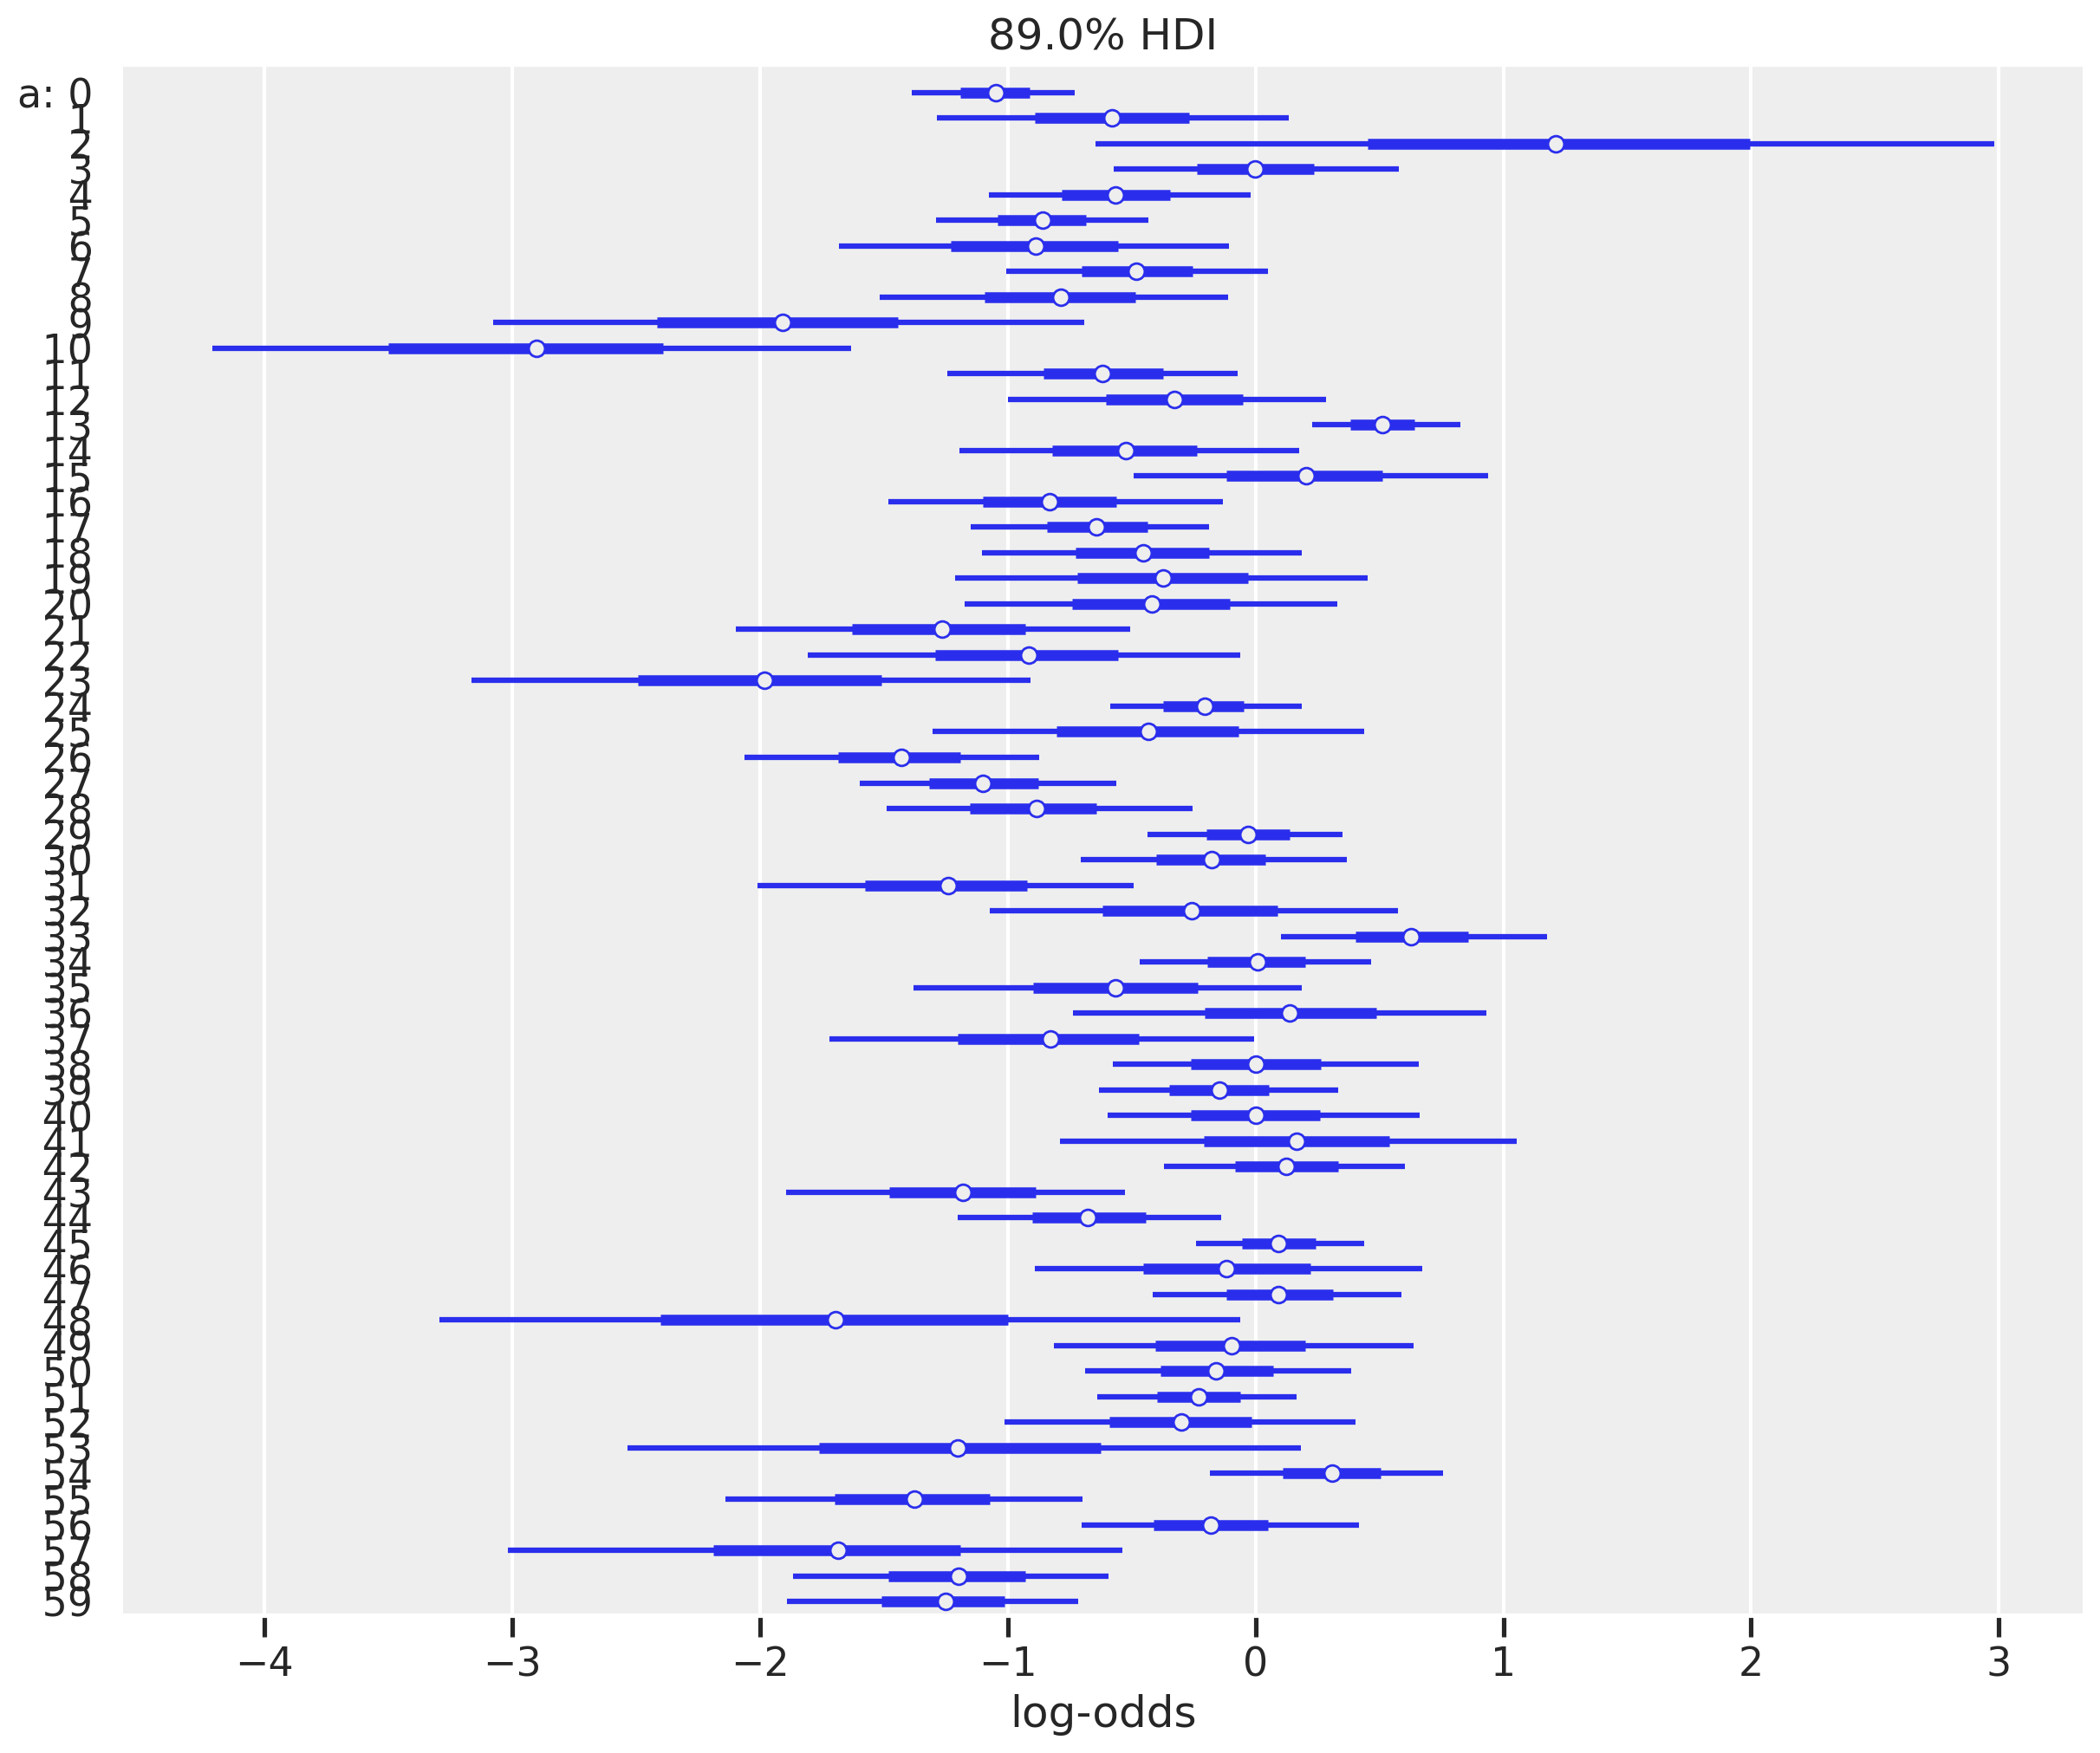

<IPython.core.display.Javascript object>

In [12]:
f, ax1 = plt.subplots(figsize=(12, 10))
az.plot_forest(trace_mfe, combined=True, ax=ax1)
ax1.set_xlabel("log-odds")

The results indicate that some districts are much less likely to use contraception (negative log-odds) than other districts (log-odds that span zero or are wholly positive).

This is seen by looking at the raw data. For example, the district indexed 10 is the most negative in terms of log-odds while index 2 is most positive. In index 10, there is no woman that has used contraception.

In [13]:
df_bangladesh[df_bangladesh["district_code"] == 10]

,woman,district,use.contraception,living.children,age.centered,urban,district_code
364,365,11,0,1,-9.5599,0,10
365,366,11,0,1,-8.5599,0,10
366,367,11,0,2,-5.5599,0,10
367,368,11,0,2,18.4400,0,10
368,369,11,0,1,-8.5599,0,10
369,370,11,0,1,-9.5599,0,10
370,371,11,0,1,-12.5590,0,10
371,372,11,0,1,3.4400,0,10
372,373,11,0,1,-8.5599,0,10
373,374,11,0,4,19.4400,0,10


<IPython.core.display.Javascript object>

## Mixed-effects model

Now let's use a mixed effects model where information is allowed to pool between clusters. This would make more sense since there's a varying number of women in each district.

In [14]:
df_bangladesh.groupby("district_code").count().iloc[:, 0].head(10)

district_code
0    117
1     20
2      2
3     30
4     39
5     65
6     18
7     37
8     23
9     13
Name: woman, dtype: int64

<IPython.core.display.Javascript object>

 For example, district index 2 has only 2 people. We identified that as a district that is most likely to use contraception in the fixed effects model but now we'd place less confidence on this point due to the low number. The mixed effects model will account for this.

**Model `mme` equation**

$$C_i \sim \text{Binomial}(1, p_i)$$

$$\text{logit}(p_i) = \alpha_{\text{district}[i]}$$

$$\alpha_j \sim \text{Normal}(\bar{\alpha}, \sigma) \tag{adaptive prior}$$

$$\bar{\alpha_j} \sim \text{Normal}(0, 1.5) \tag{regularizing prior}$$

$$\sigma \sim \text{Exponential}(1)$$

In [15]:
# multilevel model, non-centered version
with pm.Model() as m_13_2sr:

    # prior for average district
    a_bar = pm.Normal("a_bar", 0.0, 1.5)
    # prior for SD of districts
    sigma = pm.Exponential("sigma", 1.0)

    # alpha priors for each district
    a = pm.Normal("a", a_bar, sigma, shape=len(df_bangladesh["district_code"].unique()))

    # link function
    p = pm.math.invlogit(a[df_bangladesh["district_code"]])

    # likelihood, n=1 since each represents an individual woman
    c = pm.Binomial("c", n=1, p=p, observed=df_bangladesh["use.contraception"])

    trace_mme = pm.sample(draws=1000, random_seed=19, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, sigma, a_bar]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 19 seconds.


<IPython.core.display.Javascript object>

It looks like there are no divergences here so we don't have to worry about re-parameterizing. Let's take a look now.

In [16]:
az.summary(trace_mme)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a_bar,-0.540,0.088,-0.679,-0.397,0.002,0.001,3125.0,3125.0,3125.0,3066.0,1.00
a[0],-0.992,0.198,-1.299,-0.679,0.003,0.002,5931.0,5154.0,5973.0,2419.0,1.00
a[1],-0.599,0.360,-1.144,-0.001,0.004,0.004,7047.0,3716.0,7138.0,2443.0,1.01
a[2],-0.240,0.501,-1.003,0.559,0.006,0.008,7605.0,2191.0,7501.0,3176.0,1.00
a[3],-0.179,0.298,-0.652,0.309,0.004,0.004,6683.0,2486.0,6638.0,3036.0,1.00
...,...,...,...,...,...,...,...,...,...,...,...
a[56],-0.300,0.287,-0.741,0.169,0.003,0.003,7417.0,3515.0,7412.0,3092.0,1.00
a[57],-0.997,0.443,-1.680,-0.266,0.006,0.005,5220.0,3757.0,5335.0,2690.0,1.00
a[58],-0.997,0.326,-1.518,-0.490,0.004,0.003,5811.0,4553.0,6008.0,2759.0,1.00
a[59],-1.054,0.303,-1.540,-0.588,0.004,0.003,5965.0,4850.0,6009.0,2550.0,1.00


<IPython.core.display.Javascript object>

[Text(0.5, 0, 'log-odds'), Text(0.5, 1.0, 'mixed model')]

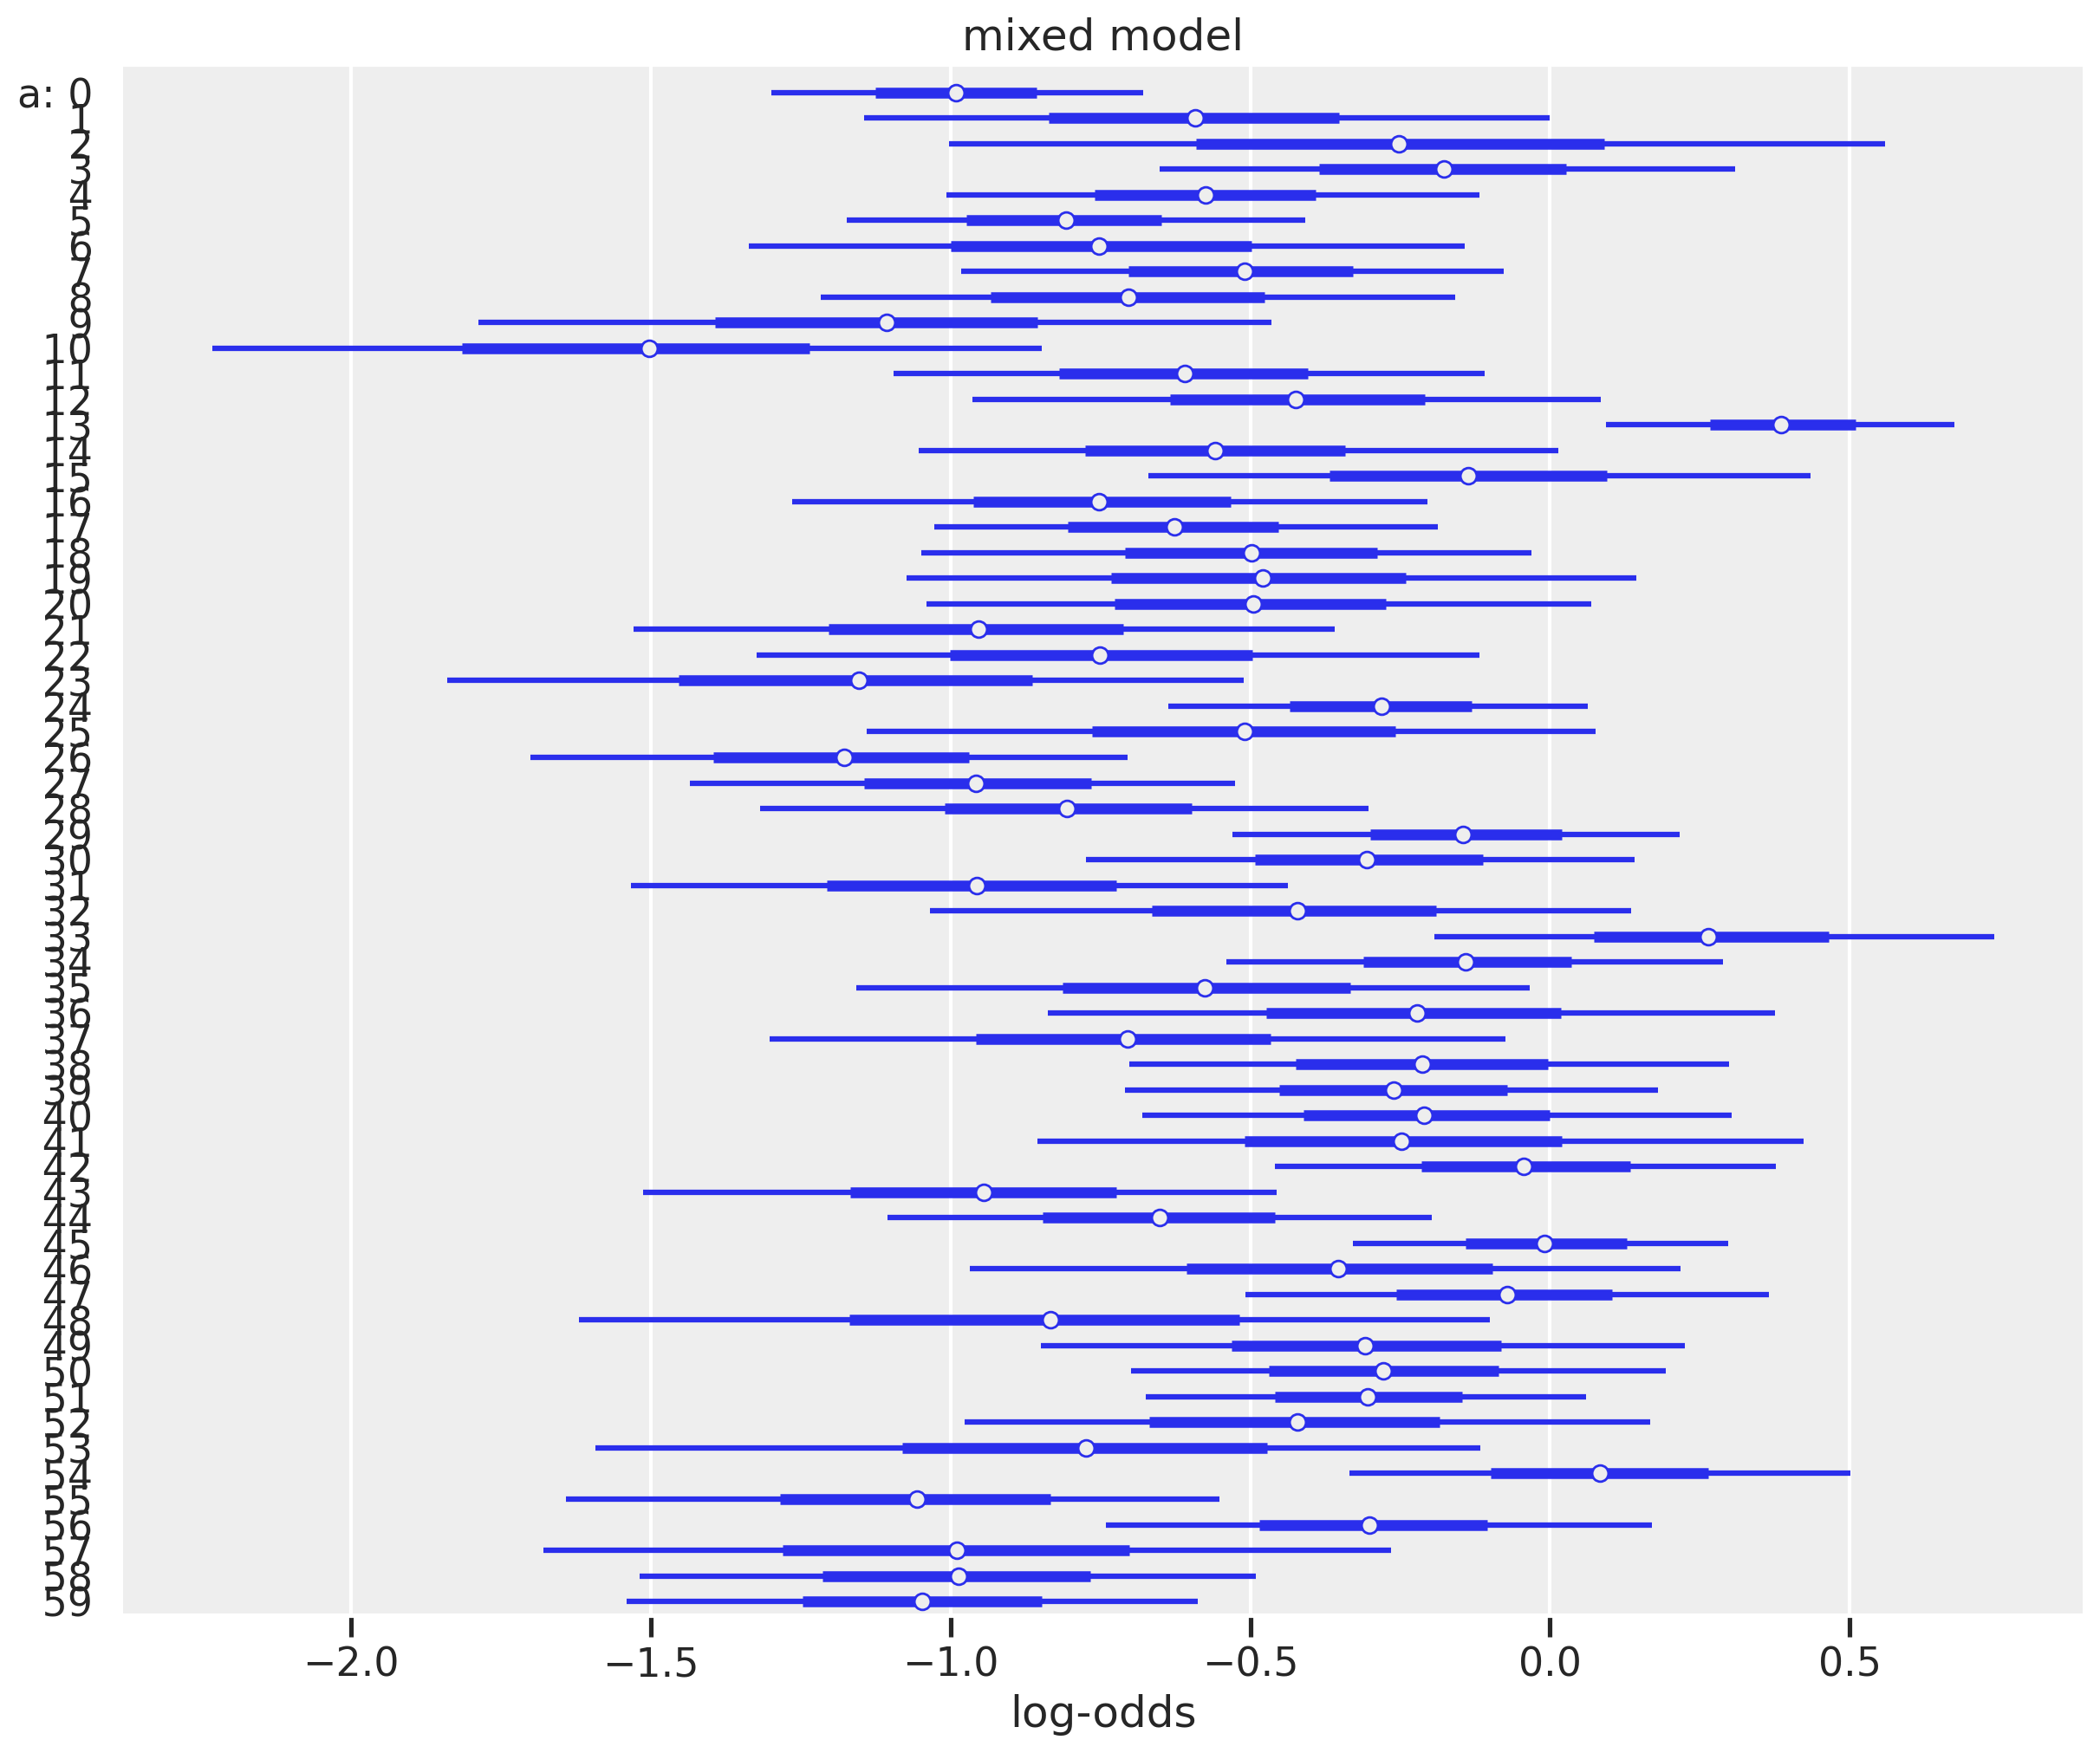

<IPython.core.display.Javascript object>

In [17]:
f, ax1 = plt.subplots(figsize=(12, 10))
az.plot_forest(trace_mme, var_names="a", combined=True, ax=ax1)
ax1.set(xlabel="log-odds", title="mixed model")

Note how the district with index 2 is a lot less confident now. The prediction interval spans log-odds of 0 now. We'll look at this more closely in the comparison.

## Comparison of fixed-effects and mixed-effects models

Let's start off by looking at how the uncertainty for each district is in the fixed-effects versus mixed-effects model for each district.

In [18]:
col2inspect = ["mean", "sd", "hdi_5.5%", "hdi_94.5%"]
df_summary = pd.merge(
    az.summary(trace_mfe)[col2inspect],
    az.summary(trace_mme)[col2inspect],
    how="inner",
    left_index=True,
    right_index=True,
)

# Reset index
df_summary.reset_index(inplace=True)

# Add number of women for each district
df_summary["n_women"] = df_bangladesh.groupby("district_code").count().iloc[:, 0]

df_summary.head()

,index,mean_x,sd_x,hdi_5.5%_x,hdi_94.5%_x,mean_y,sd_y,hdi_5.5%_y,hdi_94.5%_y,n_women
0,a[0],-1.052,0.205,-1.389,-0.730,-0.992,0.198,-1.299,-0.679,117
1,a[1],-0.584,0.452,-1.287,0.134,-0.599,0.360,-1.144,-0.001,20
2,a[2],1.240,1.156,-0.647,2.980,-0.240,0.501,-1.003,0.559,2
3,a[3],-0.003,0.362,-0.572,0.579,-0.179,0.298,-0.652,0.309,30
4,a[4],-0.569,0.330,-1.077,-0.020,-0.577,0.279,-1.007,-0.118,39


<IPython.core.display.Javascript object>

[(0.0, 1.2),
 (0.0, 1.2),
 Text(0.5, 0, 'fixed effects SD'),
 Text(0, 0.5, 'mixed effects SD')]

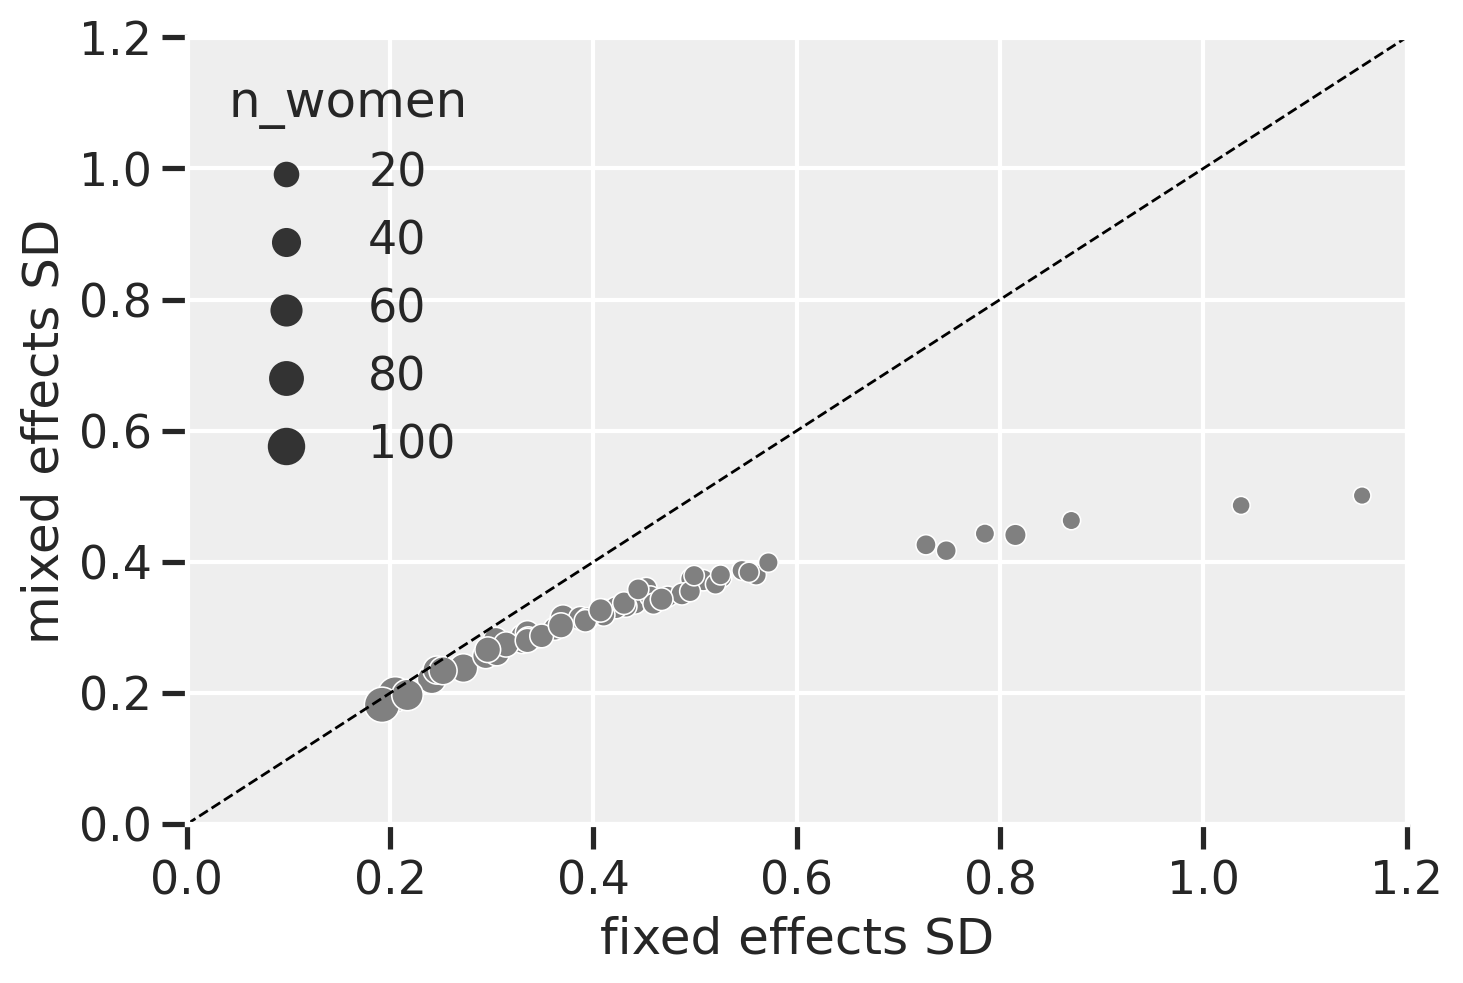

<IPython.core.display.Javascript object>

In [19]:
f, ax1 = plt.subplots()
sns.scatterplot(
    data=df_summary, x="sd_x", y="sd_y", size="n_women", color="gray", ax=ax1
)
ax1.plot([0, 1.2], [0, 1.2], color="black", lw=1, linestyle="--")
ax1.set(
    xlim=[0, 1.2], ylim=[0, 1.2], xlabel="fixed effects SD", ylabel="mixed effects SD"
)

Here, we can see that the fixed effects model shows greater uncertainty, especially when the number of women in each district gets lower. When the number of women is high, the fixed effects shows uncertainty on par with the mixed effects model. Lower uncertainty with mixed effects is due to partial pooling.

Per the homework assignment, let's plot the predicted proportion of women in each district using contraception. We'll use the `logistic` function to transform the log-odds back on the probability scale.

[(-2.0, 60.0),
 (0.0, 1.0),
 Text(0.5, 0, 'district index'),
 Text(0, 0.5, 'proportion predicted\nfor contraception use')]

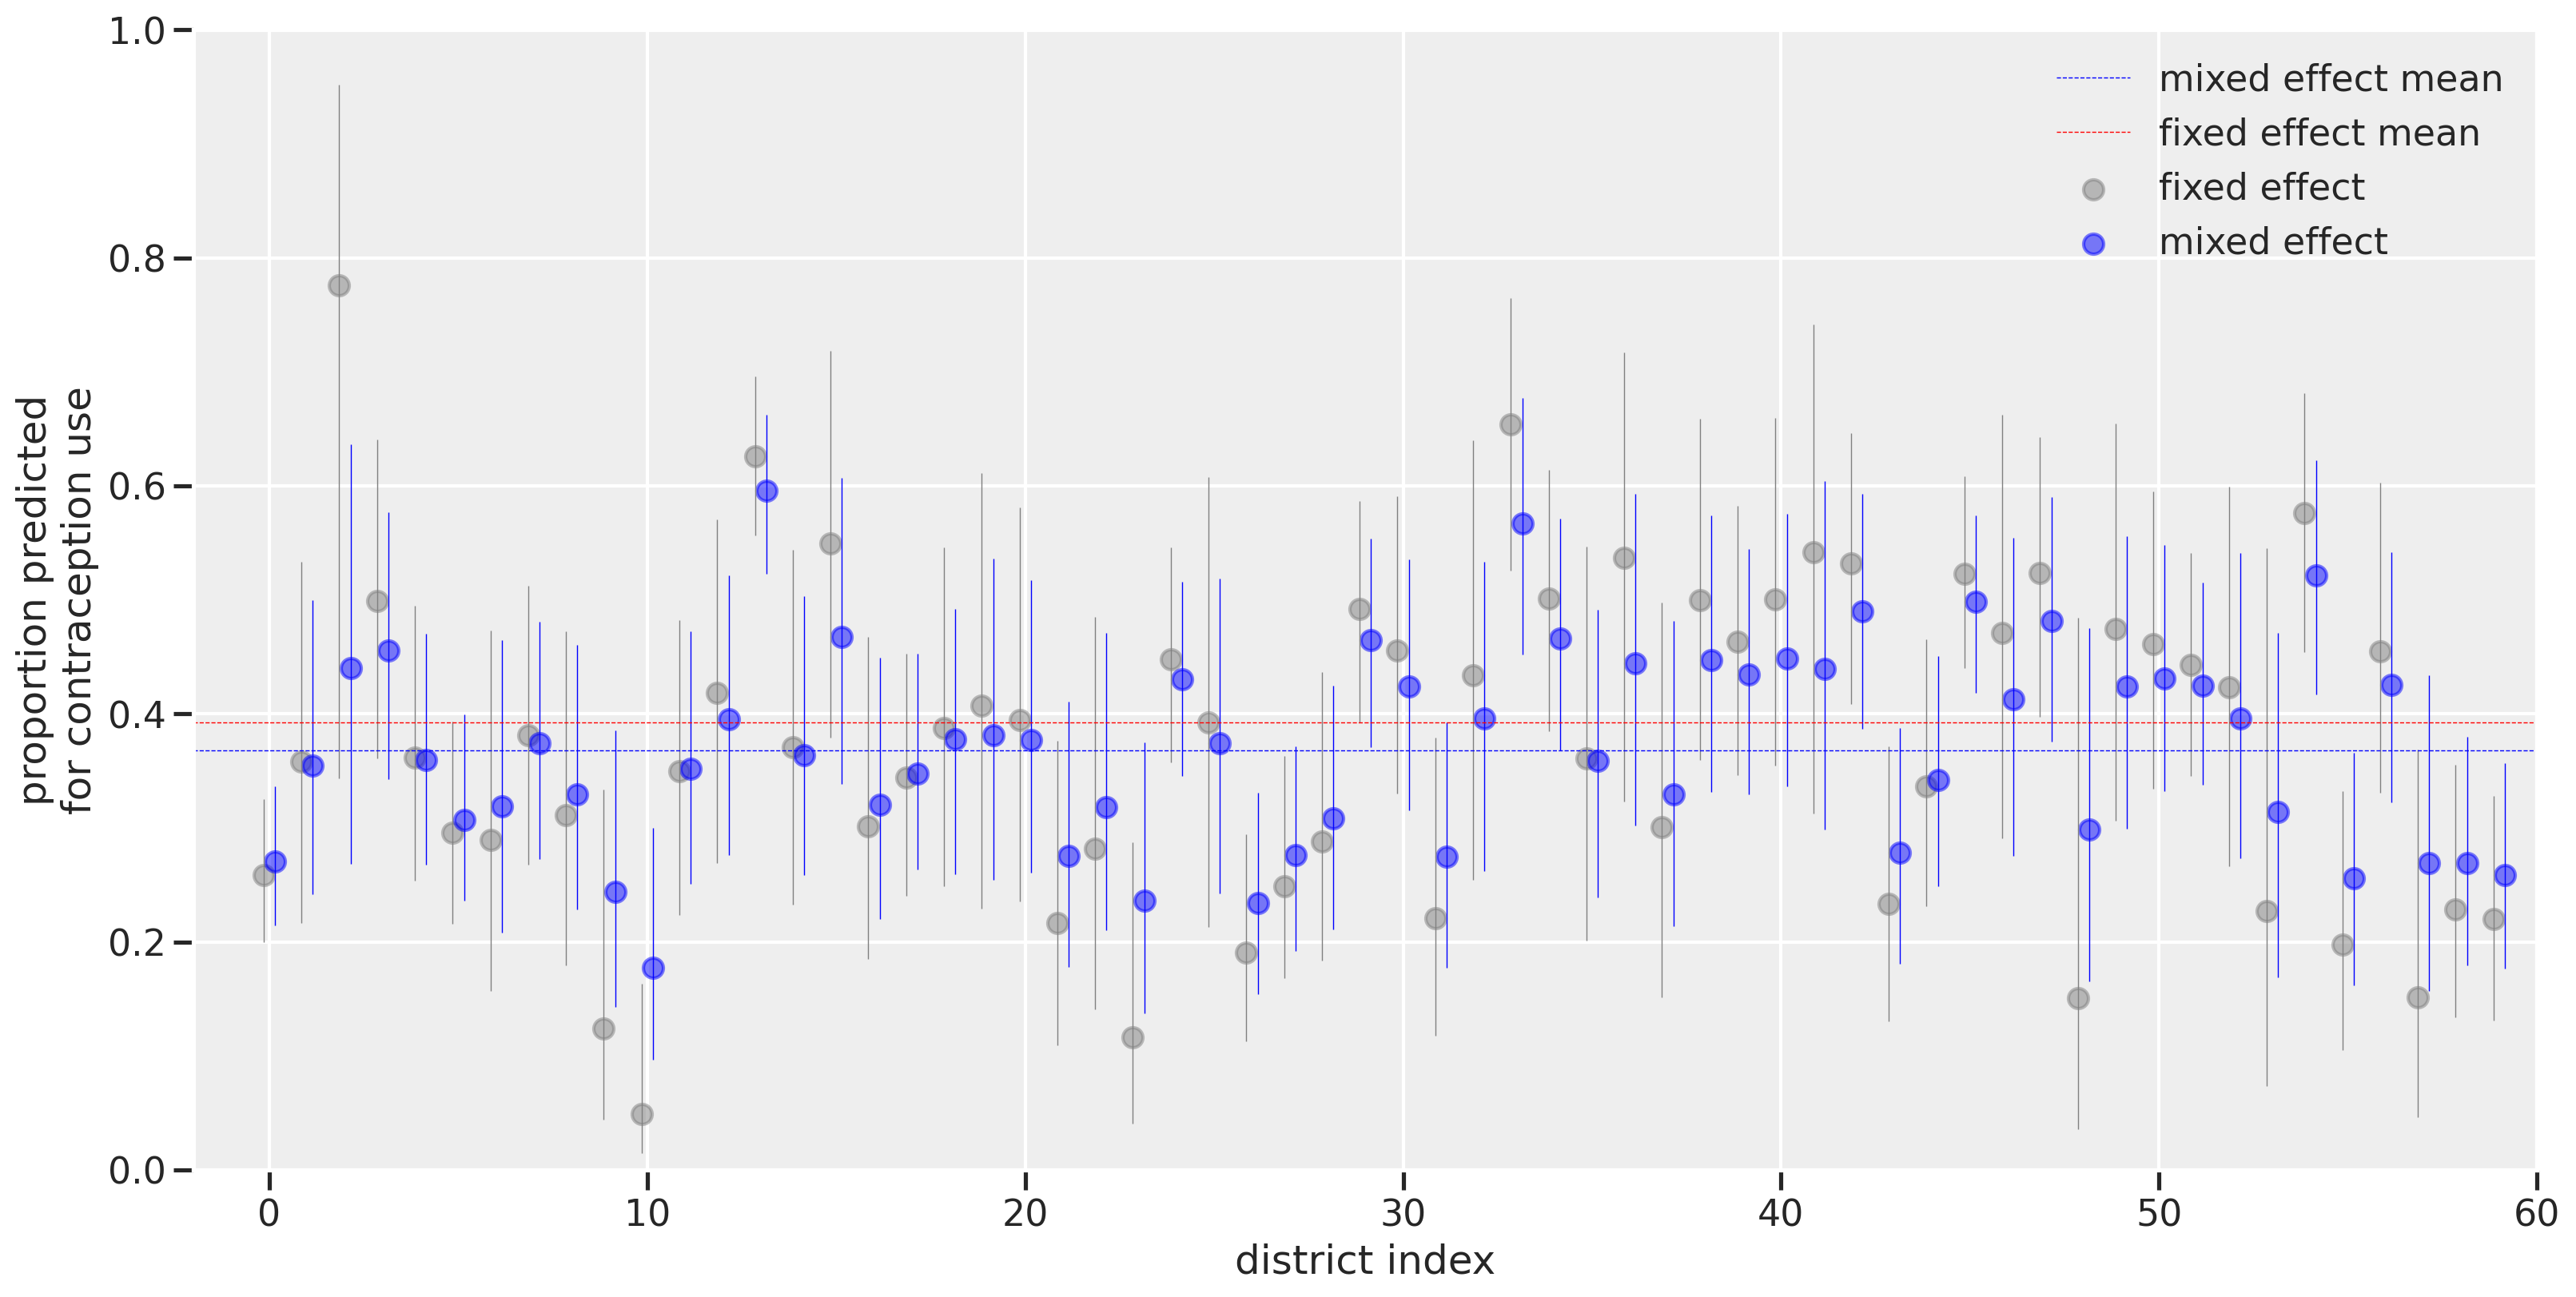

<IPython.core.display.Javascript object>

In [20]:
f, ax1 = plt.subplots(figsize=(16, 8))

# Plot means
ax1.scatter(
    df_summary.index - 0.15,
    logistic(df_summary["mean_x"]),
    color="gray",
    alpha=0.5,
    label="fixed effect",
)
ax1.scatter(
    df_summary.index + 0.15,
    logistic(df_summary["mean_y"]),
    color="blue",
    alpha=0.5,
    label="mixed effect",
)

# Plot uncertainties
ax1.vlines(
    x=df_summary.index - 0.15,
    ymin=logistic(df_summary["hdi_5.5%_x"]),
    ymax=logistic(df_summary["hdi_94.5%_x"]),
    color="gray",
    linewidth=0.5,
)

ax1.vlines(
    x=df_summary.index + 0.15,
    ymin=logistic(df_summary["hdi_5.5%_y"]),
    ymax=logistic(df_summary["hdi_94.5%_y"]),
    color="blue",
    linewidth=0.5,
)

# Plot average mixed effect line
me_mean = logistic(az.summary(trace_mme).loc["a_bar", "mean"])
ax1.plot(
    [-10, 62],
    [me_mean, me_mean],
    color="blue",
    lw=0.5,
    linestyle="--",
    alpha=1,
    label="mixed effect mean",
)

# Plot raw fixed effect line
fe_mean = df_bangladesh["use.contraception"].mean()
ax1.plot(
    [-10, 62],
    [fe_mean, fe_mean],
    color="red",
    lw=0.5,
    linestyle="--",
    alpha=1,
    label="fixed effect mean",
)

ax1.legend()
ax1.set(
    xlim=[-2, 60],
    ylim=[0, 1],
    xlabel="district index",
    ylabel="proportion predicted\nfor contraception use",
)

## Comparison with homework solution

It largely matched with McElreath's posted solutions. (The colors are flipped when comparing.) But McElreath also transformed all posterior values to probability scale first bfore taking mean.

# Question 1 (14H1)

(homework is problems 14H1-14H3).

Let’s revisit the Bangladesh fertility data, `data(bangladesh)`. Fit a model with both varying intercepts by `district_id` and varying slopes of `urban` by `district_id`. You are still predicting `use.contraception`. Inspect the correlation between the intercepts and slopes. Can you interpret this correlation, in terms of what it tells you about the pattern of contraceptive use in the sample?

It might help to plot the mean (or median) varying effect estimates for both the intercepts and slopes, by district. Then you can visualize the correlation and maybe more easily think through what it means to have a particular correlation. Plotting predicted proportion of women using contraception, with urban women on one axis and rural on the other, might also help.

I was unsure what "varying slopes of urban by `district_id`" meant so I inspected the table.

In [21]:
df_bangladesh.head()

,woman,district,use.contraception,living.children,age.centered,urban,district_code
0,1,1,0,4,18.4400,1,0
1,2,1,0,1,-5.5599,1,0
2,3,1,0,3,1.4400,1,0
3,4,1,0,4,8.4400,1,0
4,5,1,0,1,-13.5590,1,0


<IPython.core.display.Javascript object>

In [22]:
df_bangladesh[["district_code", "urban"]].drop_duplicates().sort_values(
    by=["district_code", "urban"]
)

,district_code,urban
63,0,0
0,0,1
117,1,0
137,2,1
150,3,0
...,...,...
1850,57,0
1870,58,0
1860,58,1
1903,59,0


<IPython.core.display.Javascript object>

`Urban` is a categorical index variable which states whether that woman lives in an urban part of that district. From inspection of Chapter 14 code, the setup is similar (R code 14.10 to 14.13).

## Model equation to include varying slopes

This problem is conceptually similar to Chapter 14's cafe example. I'll use that as a template for this problem. One difference though is that this problem has a Binomial likelihood while the cafe problem had a Normal likelihood. I think all we have to change, however, is that we use a link function.

**Model `mvse` equation**

$$C_i \sim \text{Binomial}(1, p_i) \tag{likelihood}$$

$$\text{logit}(p_i) = \alpha_{\text{district}[i]} + \beta_{\text{district}[i]}U_{[i]} \tag{linear model with link function}$$

Matrix of varying intercepts and slopes and its covariance matrix:


$$\begin{bmatrix}\alpha_{\text{district}} \\ \beta_{\text{district}} \end{bmatrix} \text { ~ MVNormal } \left( \begin{bmatrix}\alpha \\ \beta \end{bmatrix} , \text{S} \right)  \tag{population of varying effects} $$

In this prior, we have an intercept term for each district (average contraception use in rural only because of the slope term when U is 0) and the slope (how much it changes if a woman lives in an urban district). (This is different from problem 13H1 where the intercept term represents average across the whole district, regardless of whether it's urban or rural.) Instead of having separate lines for the prior, we put them in the same multivariate normal covariance matrix to allow information sharing between slopes and priors. This allows adaptive regularization of individual district intercepts, their slopes, and the correlation among them. 

The covariance matrix **S** is defined here. (Note: The top left of each array is isn't showing up correctly. It should be \(\sigma_{\alpha}\).)

$$ \text{S} = \left(\begin{array} \sigma_{\alpha} & 0 \\ 0 & \sigma_{\beta} \end{array}\right)  \text{R} \left(\begin{array} \sigma_{\alpha} & 0 \\ 0 & \sigma_{\beta} \end{array}\right) \tag{construct covariance matrix} $$

Why is the covariance matrix set up with separate standard deviations and a correlation matrix? way? Per the text, "splitting the covaraince up into standard deviations and correlations... [will make it] easier to later understand the inferred structure of the varying effects."

Here are the hyperprriors and priors that define the adaptive varying effects prior. In contrast to the cafe example, I'll choose slightly wider prior for \(\beta\), with normal distribution centered around 0 to be a bit more naive to the expected results. My \(\alpha\) will be the same as above. Note also that since we're not using a Normal likelihood, there's no \(\sigma\) term that would be a part of it. We still have the sigmas associated with the alpha and beta in the covariance matrix.

$$ \alpha \text { ~ Normal}(0, 1.5) \tag{prior for average intercept} $$
$$ \beta \text { ~ Normal}(0, 2)  \tag{prior for average slope} $$
$$ \sigma_{alpha} \text{ ~ Exponential}(1) \tag{prior sddev among intercepts} $$
$$ \sigma_{beta} \text{ ~ Exponential}(1) \tag{prior sddev among slopes} $$
$$ \text{R ~ LKJcorr}(2) \tag{prior for correlation matrix} $$

LKJcorr can be thought of as a "regularizing prior for correlation matrices". The LKJcorr's parameter is eta and per the text a value of 2 provides a pretty wide distribution of possible correlations centered over 0 (Figure 14.3).

In [23]:
N_districts = len(df_bangladesh["district_code"].unique())

<IPython.core.display.Javascript object>

In [24]:
df_bangladesh.head()

,woman,district,use.contraception,living.children,age.centered,urban,district_code
0,1,1,0,4,18.4400,1,0
1,2,1,0,1,-5.5599,1,0
2,3,1,0,3,1.4400,1,0
3,4,1,0,4,8.4400,1,0
4,5,1,0,1,-13.5590,1,0


<IPython.core.display.Javascript object>

In [26]:
# Used this below
from theano import tensor as tt

<IPython.core.display.Javascript object>

In [98]:
# code modified from repo and adapted for binomial likelihood

with pm.Model() as mvse:
    # LKJCholeskyCov is more efficient than LKJCorr
    # PyMC >= 3.9 extracts the stds and matrix of correlations automatically for us
    chol, Rho_, sigma_district = pm.LKJCholeskyCov(
        "chol_cov", n=2, eta=2, sd_dist=pm.Exponential.dist(1.0), compute_corr=True
    )

    a = pm.Normal("a", mu=0, sd=1.5)  # used same from previous problem
    b = pm.Normal("b", mu=0, sd=2)  # use something conservative

    ab_district = pm.MvNormal(
        "ab_district", mu=tt.stack([a, b]), chol=chol, shape=(N_districts, 2)
    )  # population of varying effects
    # shape needs to be (N_districts, 2) because we're getting back both a and b for each district

    # originally written link function
    # prevented p from being included as a parameter I could access in posterior distribution
    #     p = pm.math.invlogit(
    #         ab_district[df_bangladesh["district_code"], 0]
    #         + ab_district[df_bangladesh["district_code"], 1] * df_bangladesh["urban"]
    #     )

    # link function
    p = pm.Deterministic(
        "p",
        pm.math.invlogit(
            ab_district[df_bangladesh["district_code"], 0]
            + ab_district[df_bangladesh["district_code"], 1] * df_bangladesh["urban"]
        ),
    )

    # likelihood, n=1 since each represents an individual woman
    c = pm.Binomial("c", n=1, p=p, observed=df_bangladesh["use.contraception"])

    trace_mvse = pm.sample(draws=1000, random_seed=19, return_inferencedata=True)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ab_district, b, a, chol_cov]
INFO:pymc3:NUTS: [ab_district, b, a, chol_cov]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 88 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 88 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


<IPython.core.display.Javascript object>

In [99]:
az.summary(trace_mvse)

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/stats/diagnostics.py:642: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,-0.710,0.101,-0.879,-0.555,0.002,0.001,2554.0,2550.0,2556.0,2752.0,1.0
b,0.709,0.173,0.424,0.970,0.004,0.003,1770.0,1770.0,1771.0,2402.0,1.0
"ab_district[0,0]",-1.542,0.316,-2.051,-1.045,0.006,0.004,3243.0,3123.0,3293.0,2857.0,1.0
"ab_district[0,1]",1.066,0.391,0.420,1.657,0.007,0.005,2826.0,2550.0,2868.0,2751.0,1.0
"ab_district[1,0]",-0.677,0.371,-1.296,-0.103,0.006,0.005,3652.0,2732.0,3686.0,2544.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
p[1929],0.240,0.063,0.132,0.330,0.001,0.001,3924.0,3701.0,3912.0,2549.0,1.0
p[1930],0.240,0.063,0.132,0.330,0.001,0.001,3924.0,3701.0,3912.0,2549.0,1.0
p[1931],0.240,0.063,0.132,0.330,0.001,0.001,3924.0,3701.0,3912.0,2549.0,1.0
p[1932],0.240,0.063,0.132,0.330,0.001,0.001,3924.0,3701.0,3912.0,2549.0,1.0


<IPython.core.display.Javascript object>

## Inspection of correlation between slopes and prior

This will tell us whether living in an urban area would influence the likelihood of taking contraception. A positive correlation would tell us that across all districts with an already high average probability of taking contraception (high slopes), even more would take contraception in an urban area (high intercept). If the correlation were negative, that means women living in districts with high average probability would be *less likely* to take contraception if they were in an urban area.

Let's plot the intercepts and slopes to see what the relationship looks like. First, let's see where we can find these values in the parameters.

In [100]:
az.summary(trace_mvse, var_names="ab_district").index

Index(['ab_district[0,0]', 'ab_district[0,1]', 'ab_district[1,0]',
       'ab_district[1,1]', 'ab_district[2,0]', 'ab_district[2,1]',
       'ab_district[3,0]', 'ab_district[3,1]', 'ab_district[4,0]',
       'ab_district[4,1]',
       ...
       'ab_district[55,0]', 'ab_district[55,1]', 'ab_district[56,0]',
       'ab_district[56,1]', 'ab_district[57,0]', 'ab_district[57,1]',
       'ab_district[58,0]', 'ab_district[58,1]', 'ab_district[59,0]',
       'ab_district[59,1]'],
      dtype='object', length=120)

<IPython.core.display.Javascript object>

It looks like the district is represented in the 0th position of the index and there's two terms associate with each. The first term is the alpha term (intercepts) and the second term is the beta term (slopes). We'll plot the means of these parameters with intercepts in a scatter plot.

In [101]:
# Let's turn it into a dataframe for plotting
df_ab_district = az.summary(trace_mvse, var_names="ab_district")
df_ab_district.head()

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
"ab_district[0,0]",-1.542,0.316,-2.051,-1.045,0.006,0.004,3243.0,3123.0,3293.0,2857.0,1.0
"ab_district[0,1]",1.066,0.391,0.420,1.657,0.007,0.005,2826.0,2550.0,2868.0,2751.0,1.0
"ab_district[1,0]",-0.677,0.371,-1.296,-0.103,0.006,0.005,3652.0,2732.0,3686.0,2544.0,1.0
"ab_district[1,1]",0.686,0.672,-0.350,1.775,0.011,0.009,3832.0,2573.0,3811.0,2866.0,1.0
"ab_district[2,0]",-0.686,0.583,-1.579,0.221,0.010,0.008,3254.0,2808.0,3264.0,2690.0,1.0


<IPython.core.display.Javascript object>

[Text(0.5, 0, 'intercepts (a_district)'),
 Text(0, 0.5, 'slopes (b_district)'),
 Text(0.5, 1.0, 'intercepts vs. slopes')]

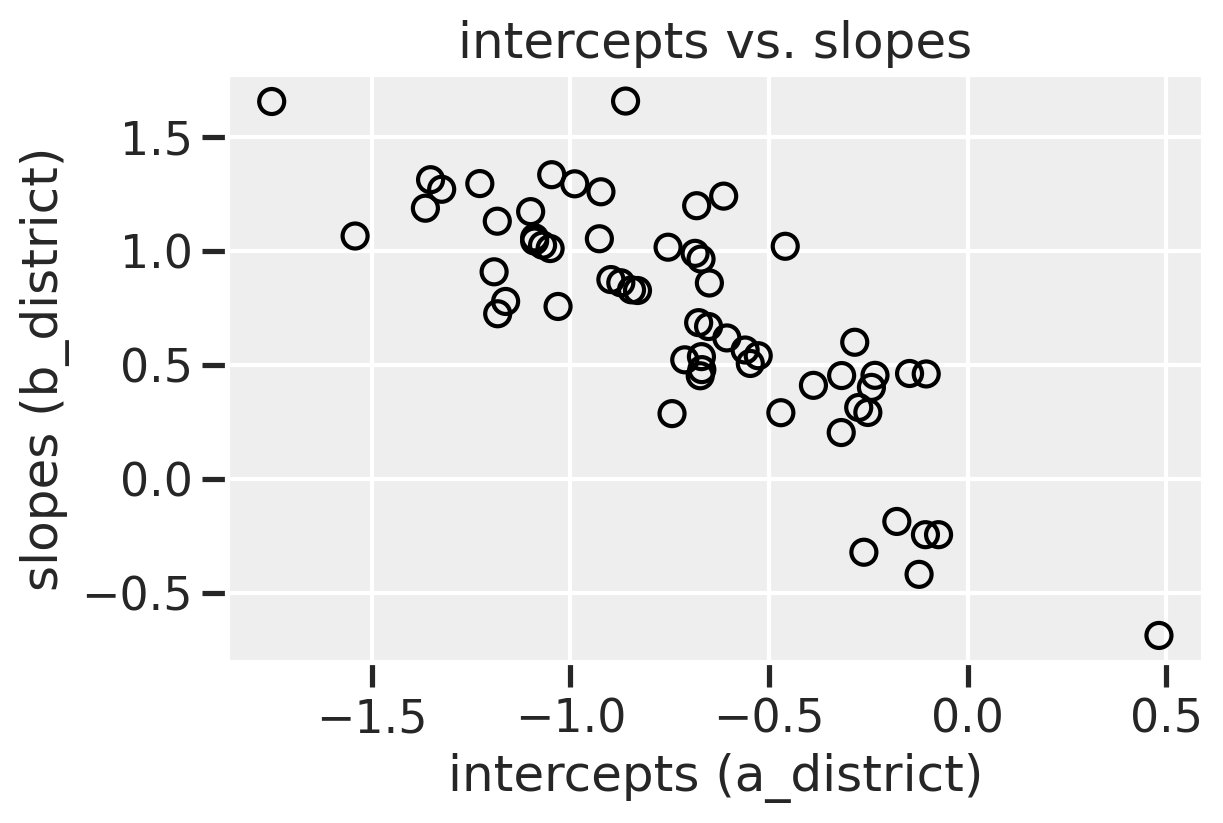

<IPython.core.display.Javascript object>

In [102]:
# Can add concentric circles later
f, ax1 = plt.subplots(1, 1, figsize=(6, 4))
for i in range(60):
    ax1.scatter(
        df_ab_district.loc["ab_district[" + str(i) + ",0]", "mean"],
        df_ab_district.loc["ab_district[" + str(i) + ",1]", "mean"],
        facecolors="none",
        edgecolors="black",
    )

ax1.set(
    xlabel="intercepts (a_district)",
    ylabel="slopes (b_district)",
    title="intercepts vs. slopes",
)

We see a negative correlation, which is also confirmed by inspecting the posterior distribution for the value for rho in the Cholevsky correlation matrix.

In [103]:
# Inspect off-diagonal values
az.summary(trace_mvse, var_names="chol_cov_corr")

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/stats/diagnostics.py:642: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
"chol_cov_corr[0,0]",1.000,0.000,1.000,1.000,0.000,0.000,4000.0,4000.0,4000.0,4000.0,NaN
"chol_cov_corr[0,1]",-0.654,0.167,-0.905,-0.432,0.006,0.004,703.0,703.0,691.0,1231.0,1.0
"chol_cov_corr[1,0]",-0.654,0.167,-0.905,-0.432,0.006,0.004,703.0,703.0,691.0,1231.0,1.0
"chol_cov_corr[1,1]",1.000,0.000,1.000,1.000,0.000,0.000,4000.0,4000.0,3979.0,3973.0,1.0


<IPython.core.display.Javascript object>

Let's plot the prior and posterior distribution of the correlation between intercepts and slopes.

In [104]:
trace_mvse_df = trace_mvse.to_dataframe()

<IPython.core.display.Javascript object>

In [106]:
[print(col) for col in trace_mvse_df.columns]

chain
draw
('posterior', 'a')
('posterior', 'b')
('posterior', 'ab_district[0,0]', 0, 0)
('posterior', 'ab_district[0,1]', 0, 1)
('posterior', 'ab_district[1,0]', 1, 0)
('posterior', 'ab_district[1,1]', 1, 1)
('posterior', 'ab_district[10,0]', 10, 0)
('posterior', 'ab_district[10,1]', 10, 1)
('posterior', 'ab_district[11,0]', 11, 0)
('posterior', 'ab_district[11,1]', 11, 1)
('posterior', 'ab_district[12,0]', 12, 0)
('posterior', 'ab_district[12,1]', 12, 1)
('posterior', 'ab_district[13,0]', 13, 0)
('posterior', 'ab_district[13,1]', 13, 1)
('posterior', 'ab_district[14,0]', 14, 0)
('posterior', 'ab_district[14,1]', 14, 1)
('posterior', 'ab_district[15,0]', 15, 0)
('posterior', 'ab_district[15,1]', 15, 1)
('posterior', 'ab_district[16,0]', 16, 0)
('posterior', 'ab_district[16,1]', 16, 1)
('posterior', 'ab_district[17,0]', 17, 0)
('posterior', 'ab_district[17,1]', 17, 1)
('posterior', 'ab_district[18,0]', 18, 0)
('posterior', 'ab_district[18,1]', 18, 1)
('posterior', 'ab_district[19,0]', 

('posterior', 'p[716]', 716)
('posterior', 'p[717]', 717)
('posterior', 'p[718]', 718)
('posterior', 'p[719]', 719)
('posterior', 'p[71]', 71)
('posterior', 'p[720]', 720)
('posterior', 'p[721]', 721)
('posterior', 'p[722]', 722)
('posterior', 'p[723]', 723)
('posterior', 'p[724]', 724)
('posterior', 'p[725]', 725)
('posterior', 'p[726]', 726)
('posterior', 'p[727]', 727)
('posterior', 'p[728]', 728)
('posterior', 'p[729]', 729)
('posterior', 'p[72]', 72)
('posterior', 'p[730]', 730)
('posterior', 'p[731]', 731)
('posterior', 'p[732]', 732)
('posterior', 'p[733]', 733)
('posterior', 'p[734]', 734)
('posterior', 'p[735]', 735)
('posterior', 'p[736]', 736)
('posterior', 'p[737]', 737)
('posterior', 'p[738]', 738)
('posterior', 'p[739]', 739)
('posterior', 'p[73]', 73)
('posterior', 'p[740]', 740)
('posterior', 'p[741]', 741)
('posterior', 'p[742]', 742)
('posterior', 'p[743]', 743)
('posterior', 'p[744]', 744)
('posterior', 'p[745]', 745)
('posterior', 'p[746]', 746)
('posterior', 'p[747

('log_likelihood', 'c[324]', 324)
('log_likelihood', 'c[325]', 325)
('log_likelihood', 'c[326]', 326)
('log_likelihood', 'c[327]', 327)
('log_likelihood', 'c[328]', 328)
('log_likelihood', 'c[329]', 329)
('log_likelihood', 'c[32]', 32)
('log_likelihood', 'c[330]', 330)
('log_likelihood', 'c[331]', 331)
('log_likelihood', 'c[332]', 332)
('log_likelihood', 'c[333]', 333)
('log_likelihood', 'c[334]', 334)
('log_likelihood', 'c[335]', 335)
('log_likelihood', 'c[336]', 336)
('log_likelihood', 'c[337]', 337)
('log_likelihood', 'c[338]', 338)
('log_likelihood', 'c[339]', 339)
('log_likelihood', 'c[33]', 33)
('log_likelihood', 'c[340]', 340)
('log_likelihood', 'c[341]', 341)
('log_likelihood', 'c[342]', 342)
('log_likelihood', 'c[343]', 343)
('log_likelihood', 'c[344]', 344)
('log_likelihood', 'c[345]', 345)
('log_likelihood', 'c[346]', 346)
('log_likelihood', 'c[347]', 347)
('log_likelihood', 'c[348]', 348)
('log_likelihood', 'c[349]', 349)
('log_likelihood', 'c[34]', 34)
('log_likelihood', '

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

<IPython.core.display.Javascript object>

In [107]:
# Get posterior of the rho value
trace_mvse_df[("posterior", "chol_cov_corr[0,1]", 0, 1)]

0      -0.781319
1      -0.863538
2      -0.531439
3      -0.581260
4      -0.581571
          ...   
3995   -0.802648
3996   -0.828686
3997   -0.810492
3998   -0.821354
3999   -0.818089
Name: (posterior, chol_cov_corr[0,1], 0, 1), Length: 4000, dtype: float64

<IPython.core.display.Javascript object>

[Text(0.5, 0, 'rho (correlation factor)'),
 Text(0, 0.5, 'density'),
 Text(0.5, 1.0, 'Distribution of correlation values')]

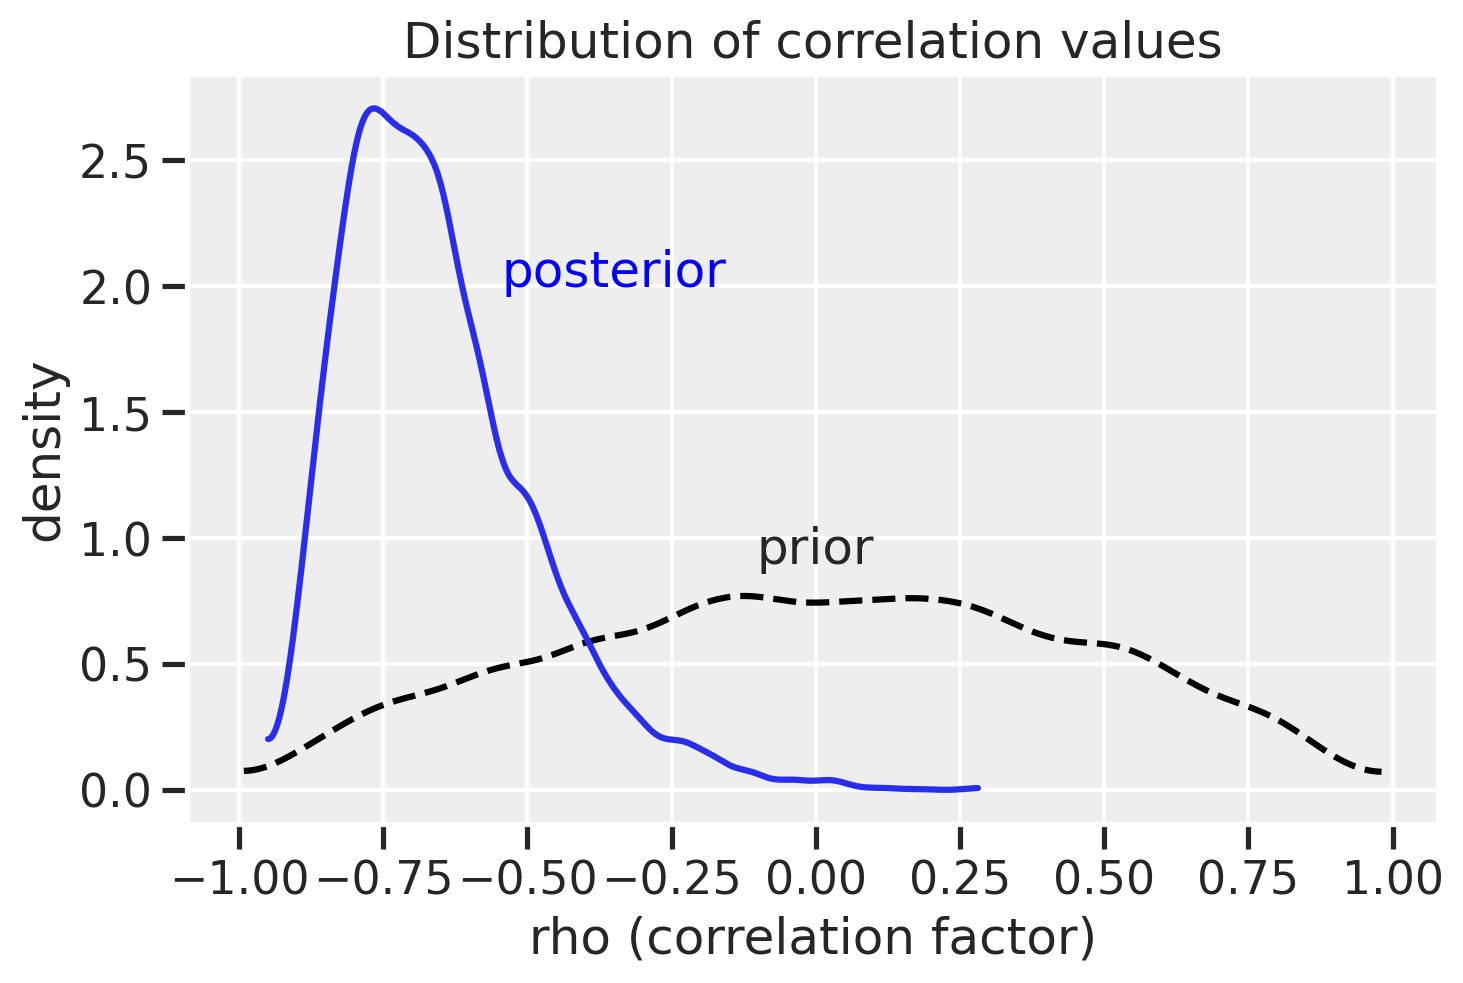

<IPython.core.display.Javascript object>

In [108]:
# Code informed/modified from repo
f, ax1 = plt.subplots()

# prior
R = pm.LKJCorr.dist(n=2, eta=2).random(size=10000)
az.plot_kde(R, plot_kwargs={"color": "k", "linestyle": "--"}, ax=ax1)
ax1.text(0, 0.9, "prior", horizontalalignment="center")

# posterior
az.plot_kde(trace_mvse_df[("posterior", "chol_cov_corr[0,1]", 0, 1)], ax=ax1)
ax1.text(-0.35, 2.0, "posterior", horizontalalignment="center", color="blue")

ax1.set(
    xlabel="rho (correlation factor)",
    ylabel="density",
    title="Distribution of correlation values",
)

## Plot predicted proportion of women using contraception for each district

Scatterplot of urban vs. rural.

### Sidebar: How come I can't get "p"?  (START)

I have trouble getting p. Why isn't it a parameter that was kept? Maybe how I setup my model?

Here's how I set it up before and how I'll try to do it:

```
# link function
p = pm.math.invlogit(a[df_bangladesh["district_code"]])

# new link function
p = pm.Deterministic("p", pm.math.invlogit(a[df_bangladesh["district_code"]]))
```

In [95]:
# multilevel model, non-centered version
with pm.Model() as m_13_2sr2:

    # prior for average district
    a_bar = pm.Normal("a_bar", 0.0, 1.5)
    # prior for SD of districts
    sigma = pm.Exponential("sigma", 1.0)

    # alpha priors for each district
    a = pm.Normal("a", a_bar, sigma, shape=len(df_bangladesh["district_code"].unique()))

    # link function
    # p = pm.math.invlogit(a[df_bangladesh["district_code"]])

    # new link function
    p = pm.Deterministic("p", pm.math.invlogit(a[df_bangladesh["district_code"]]))

    # likelihood, n=1 since each represents an individual woman
    c = pm.Binomial("c", n=1, p=p, observed=df_bangladesh["use.contraception"])

    trace_mme2 = pm.sample(draws=1000, random_seed=19, return_inferencedata=True)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, sigma, a_bar]
INFO:pymc3:NUTS: [a, sigma, a_bar]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 22 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 22 seconds.


<IPython.core.display.Javascript object>

In [96]:
az.summary(trace_mme2, var_names="p")

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
p[0],0.272,0.039,0.214,0.337,0.000,0.000,6065.0,5885.0,5973.0,2419.0,1.0
p[1],0.272,0.039,0.214,0.337,0.000,0.000,6065.0,5885.0,5973.0,2419.0,1.0
p[2],0.272,0.039,0.214,0.337,0.000,0.000,6065.0,5885.0,5973.0,2419.0,1.0
p[3],0.272,0.039,0.214,0.337,0.000,0.000,6065.0,5885.0,5973.0,2419.0,1.0
p[4],0.272,0.039,0.214,0.337,0.000,0.000,6065.0,5885.0,5973.0,2419.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
p[1929],0.263,0.057,0.171,0.351,0.001,0.001,6079.0,5593.0,6009.0,2550.0,1.0
p[1930],0.263,0.057,0.171,0.351,0.001,0.001,6079.0,5593.0,6009.0,2550.0,1.0
p[1931],0.263,0.057,0.171,0.351,0.001,0.001,6079.0,5593.0,6009.0,2550.0,1.0
p[1932],0.263,0.057,0.171,0.351,0.001,0.001,6079.0,5593.0,6009.0,2550.0,1.0


<IPython.core.display.Javascript object>

Yes, I think the way I wrote the link function influenced whether it would be part of the posterior distribution that I can access.

### Sidebar: How come I can't get "p"?  (END)

After the above lesson, I re-ran the model with the right implementation. Here are the posterior mean values.

In [111]:
df_summary_p = az.summary(trace_mvse, var_names="p")
df_summary_p

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
p[0],0.385,0.056,0.292,0.469,0.001,0.001,1942.0,1866.0,1951.0,1558.0,1.0
p[1],0.385,0.056,0.292,0.469,0.001,0.001,1942.0,1866.0,1951.0,1558.0,1.0
p[2],0.385,0.056,0.292,0.469,0.001,0.001,1942.0,1866.0,1951.0,1558.0,1.0
p[3],0.385,0.056,0.292,0.469,0.001,0.001,1942.0,1866.0,1951.0,1558.0,1.0
p[4],0.385,0.056,0.292,0.469,0.001,0.001,1942.0,1866.0,1951.0,1558.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
p[1929],0.240,0.063,0.132,0.330,0.001,0.001,3924.0,3701.0,3912.0,2549.0,1.0
p[1930],0.240,0.063,0.132,0.330,0.001,0.001,3924.0,3701.0,3912.0,2549.0,1.0
p[1931],0.240,0.063,0.132,0.330,0.001,0.001,3924.0,3701.0,3912.0,2549.0,1.0
p[1932],0.240,0.063,0.132,0.330,0.001,0.001,3924.0,3701.0,3912.0,2549.0,1.0


<IPython.core.display.Javascript object>

In [133]:
df_bangladesh_temp = df_bangladesh.copy()
df_bangladesh_temp["post_p"] = df_summary_p.iloc[:, 0].tolist()

<IPython.core.display.Javascript object>

In [136]:
df_bangladesh_temp.sort_values(by=["district_code", "urban"])

,woman,district,use.contraception,living.children,age.centered,urban,district_code,post_p
63,64,1,0,4,11.4400,0,0,0.181
64,65,1,0,4,-4.5599,0,0,0.181
65,66,1,0,4,10.4400,0,0,0.181
66,67,1,0,4,4.4400,0,0,0.181
67,68,1,0,4,-3.5599,0,0,0.181
...,...,...,...,...,...,...,...,...
1898,1899,61,1,4,-3.5599,1,59,0.393
1899,1900,61,0,1,-12.5600,1,59,0.393
1900,1901,61,0,4,12.4400,1,59,0.393
1901,1902,61,0,3,0.4400,1,59,0.393


<IPython.core.display.Javascript object>

In [141]:
df_bangladesh_temp[df_bangladesh_temp.loc[:, "district_code"] == 0]

,woman,district,use.contraception,living.children,age.centered,urban,district_code,post_p
0,1,1,0,4,18.4400,1,0,0.385
1,2,1,0,1,-5.5599,1,0,0.385
2,3,1,0,3,1.4400,1,0,0.385
3,4,1,0,4,8.4400,1,0,0.385
4,5,1,0,1,-13.5590,1,0,0.385
...,...,...,...,...,...,...,...,...
112,113,1,0,3,3.4400,0,0,0.181
113,114,1,0,1,-1.5599,0,0,0.181
114,115,1,0,4,3.4400,0,0,0.181
115,116,1,0,4,-1.5599,0,0,0.181


<IPython.core.display.Javascript object>

The posterior prediction is the same for each woman in the same district and urban code. We can get the fixed and multilevel model estimates this way.

In [145]:
df_bangladesh_temp2 = df_bangladesh_temp.groupby(["district_code", "urban"]).mean(
    "use.contraception"
)[["use.contraception", "post_p"]]

df_bangladesh_temp2.reset_index(inplace=True)

df_bangladesh_temp2.columns = [
    "district_code",
    "urban",
    "use.contraception_fixed",
    "use.contraception_mixed",
]

df_bangladesh_temp2

,district_code,urban,use.contraception_fixed,use.contraception_mixed
0,0,0,0.129630,0.181
1,0,1,0.365079,0.385
2,1,0,0.350000,0.342
3,2,1,1.000000,0.570
4,3,0,0.263158,0.303
...,...,...,...,...
97,57,0,0.100000,0.245
98,58,0,0.181818,0.245
99,58,1,0.300000,0.410
100,59,0,0.193548,0.240


<IPython.core.display.Javascript object>

In [158]:
df_bangladesh_temp2["district_code"].value_counts()

0     2
26    2
28    2
29    2
32    2
33    2
34    2
35    2
37    2
38    2
39    2
40    2
41    2
42    2
44    2
45    2
46    2
47    2
49    2
50    2
51    2
54    2
55    2
56    2
58    2
27    2
30    2
59    2
17    2
7     2
11    2
12    2
24    2
13    2
14    2
15    2
18    2
20    2
5     2
4     2
3     2
8     2
48    1
52    1
6     1
53    1
57    1
2     1
25    1
9     1
10    1
16    1
36    1
19    1
21    1
22    1
31    1
1     1
23    1
43    1
Name: district_code, dtype: int64

<IPython.core.display.Javascript object>

Note that not all districts have both urban and rural so I'll just stick to those that have both.

In [165]:
districts_with2 = (
    df_bangladesh_temp2["district_code"]
    .value_counts()[(df_bangladesh_temp2["district_code"].value_counts() == 2)]
    .index
)

<IPython.core.display.Javascript object>

In [167]:
df_bangladesh_temp3 = df_bangladesh_temp2.loc[
    df_bangladesh_temp2["district_code"].isin(districts_with2), :
]

<IPython.core.display.Javascript object>

In [168]:
df_bangladesh_temp3.shape

(84, 4)

<IPython.core.display.Javascript object>

In [170]:
df_bangladesh_temp3["district_code"].unique()

array([ 0,  3,  4,  5,  7,  8, 11, 12, 13, 14, 15, 17, 18, 20, 24, 26, 27,
       28, 29, 30, 32, 33, 34, 35, 37, 38, 39, 40, 41, 42, 44, 45, 46, 47,
       49, 50, 51, 54, 55, 56, 58, 59])

<IPython.core.display.Javascript object>

[(-0.05, 1.05),
 (-0.05, 1.05),
 Text(0.5, 0, 'proportion of rural women\nusing contraception'),
 Text(0, 0.5, 'proportion of urban women\nusing contraception'),
 Text(0.5, 1.0, 'fixed effects model')]

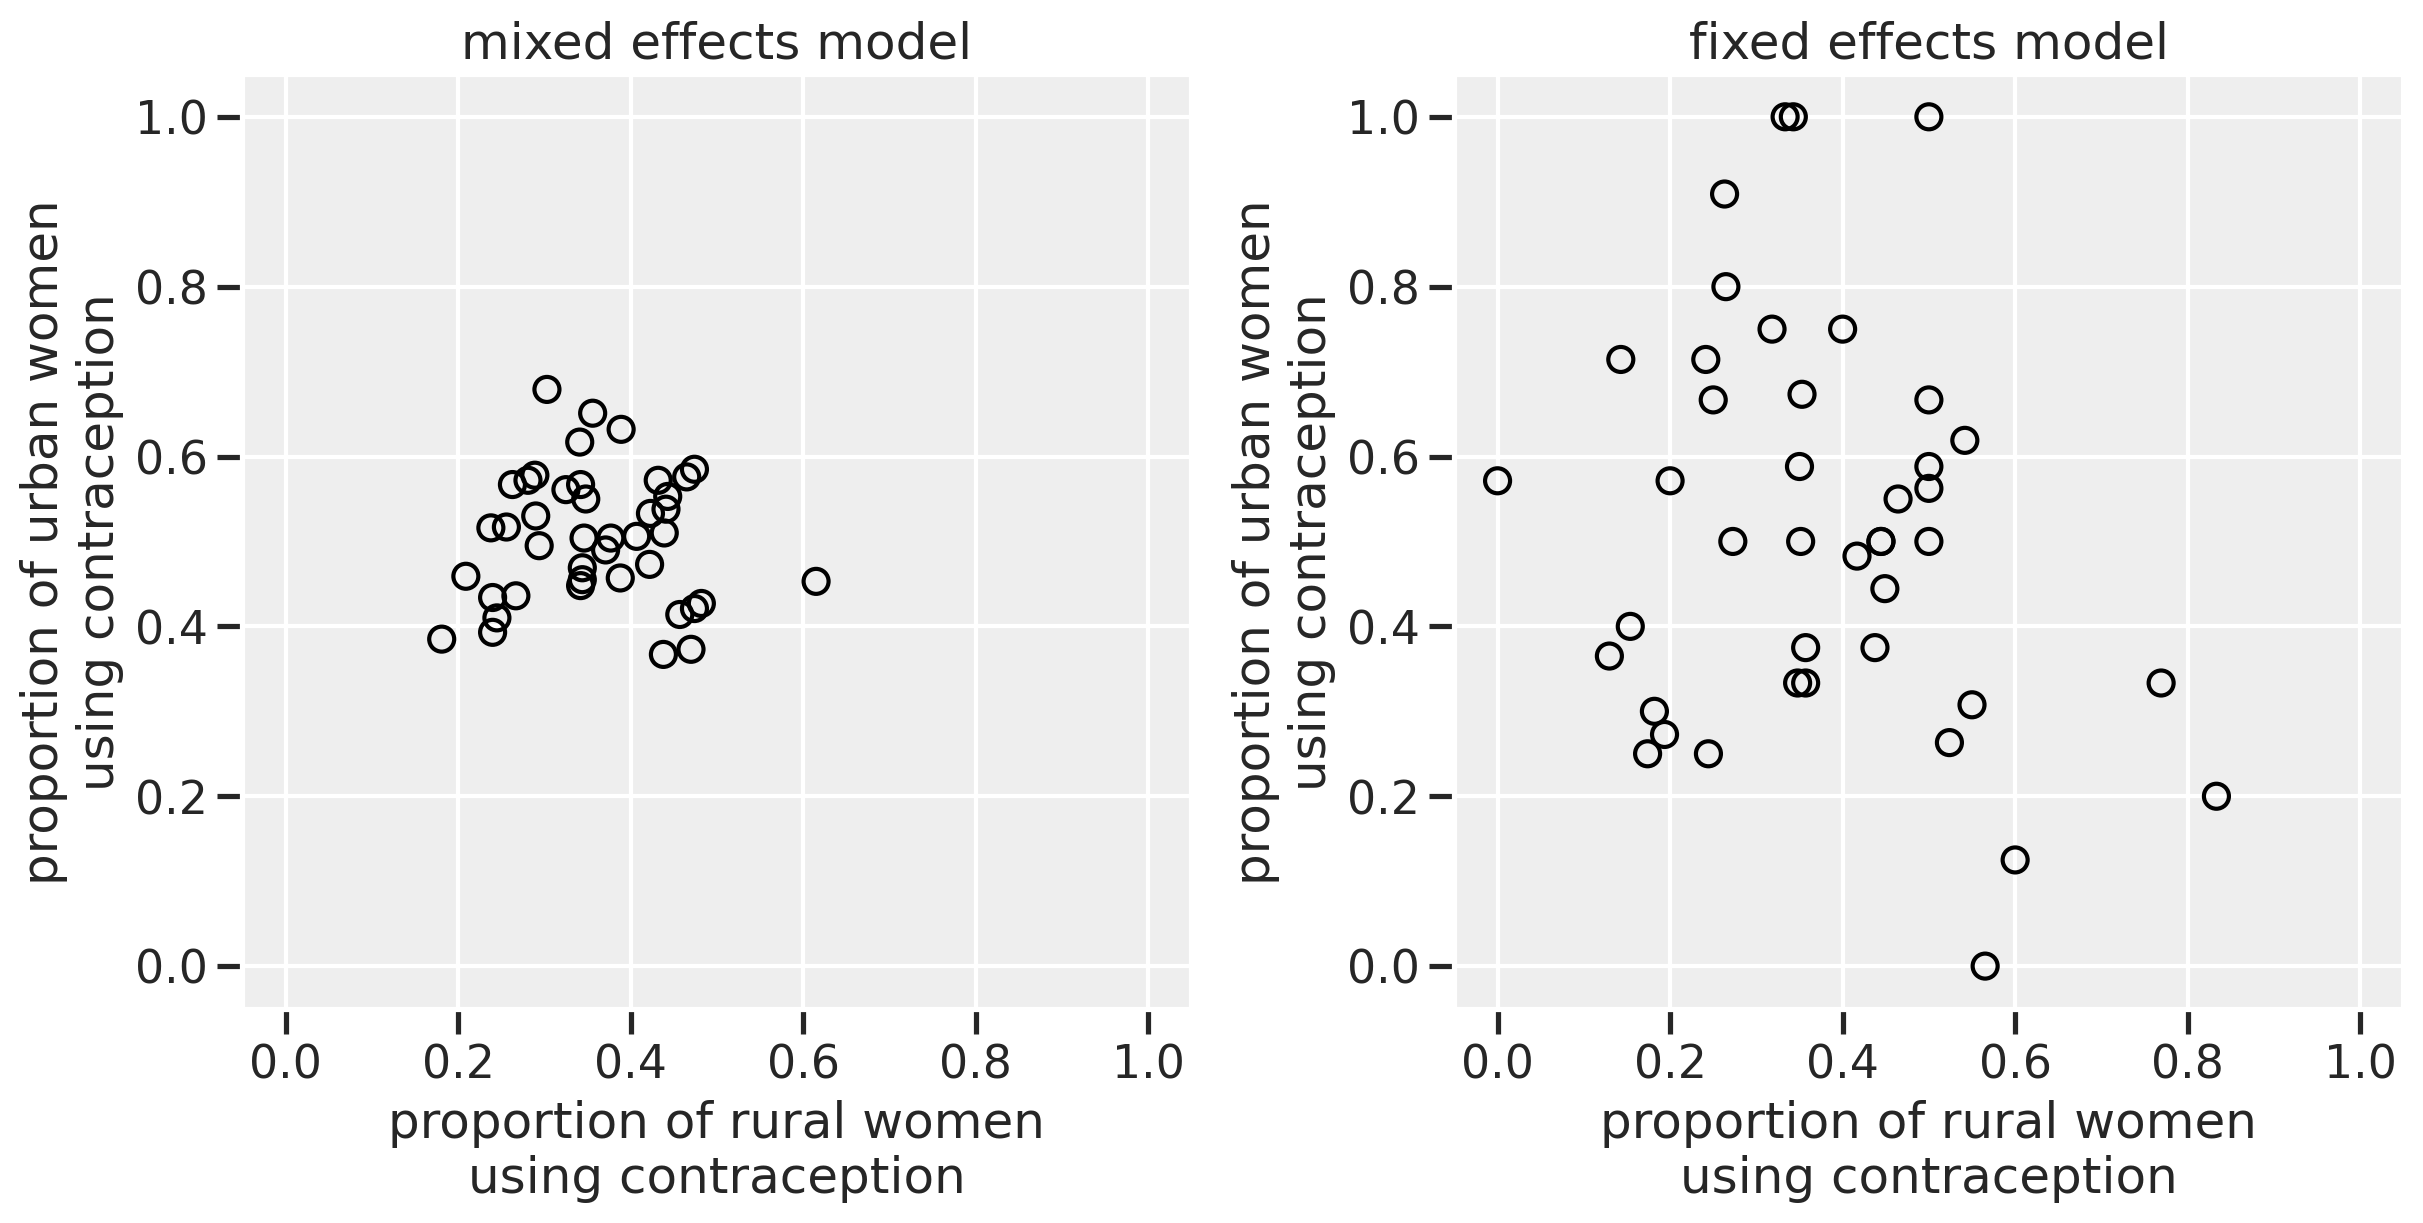

<IPython.core.display.Javascript object>

In [188]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

for district in df_bangladesh_temp3["district_code"].unique():
    bool_row_urban = (df_bangladesh_temp3["district_code"] == district) & (
        df_bangladesh_temp2["urban"] == 1
    )
    bool_row_rural = (df_bangladesh_temp3["district_code"] == district) & (
        df_bangladesh_temp2["urban"] == 0
    )

    # rural on x-xaxis and urban on y-axis to match solutions
    ax1.scatter(
        df_bangladesh_temp3.loc[bool_row_rural, "use.contraception_mixed"],
        df_bangladesh_temp3.loc[bool_row_urban, "use.contraception_mixed"],
        facecolors="none",
        edgecolors="black",
    )

ax1.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    xlabel="proportion of rural women\nusing contraception",
    ylabel="proportion of urban women\nusing contraception",
    title="mixed effects model",
)


for district in df_bangladesh_temp3["district_code"].unique():
    bool_row_urban = (df_bangladesh_temp3["district_code"] == district) & (
        df_bangladesh_temp2["urban"] == 1
    )
    bool_row_rural = (df_bangladesh_temp3["district_code"] == district) & (
        df_bangladesh_temp2["urban"] == 0
    )

    # rural on x-xaxis and urban on y-axis to match solutions
    ax2.scatter(
        df_bangladesh_temp3.loc[bool_row_rural, "use.contraception_fixed"],
        df_bangladesh_temp3.loc[bool_row_urban, "use.contraception_fixed"],
        facecolors="none",
        edgecolors="black",
    )

ax2.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    xlabel="proportion of rural women\nusing contraception",
    ylabel="proportion of urban women\nusing contraception",
    title="fixed effects model",
)

Note how the mixed effects model imposes a lot of shrinkage by accounting for the sample size differences with each district.

## Comparing with online solutions

I got largely the same results. I could've also looked at the \(\alpha\) and \(\beta\) averages for a quicker snapshot. There's also some more explanation in terms of interpretation: "Since the slope is the difference between urban and non-urban areas, you can see this as saying that districts with high use in rural areas
have urban areas that aren’t as different."

# 14H2

Now consider the predictor variables `age.centered` and `living.children`, also contained in `data(bangladesh)` Suppose that age influences contraceptive use (changing attitudes) and number of children (older people have had more time to have kids). Number of children may also directly influence contraceptive use. Draw a DAG that reflects these hypothetical relationships. Then build models needed to evaluate the DAG. You will need at least two models. Retain `district` and `urban`, as in 14H1. What do you conclude about the causal influence of age and children?

In [15]:
df_bangladesh = pd.read_csv(
    "../pymc3_ed_resources/resources/Rethinking/Data/bangladesh.csv",
    delimiter=";",
)
# Fix the district variable
df_bangladesh["district_code"] = pd.Categorical(df_bangladesh["district"]).codes
df_bangladesh.head()

,woman,district,use.contraception,living.children,age.centered,urban,district_code
0,1,1,0,4,18.4400,1,0
1,2,1,0,1,-5.5599,1,0
2,3,1,0,3,1.4400,1,0
3,4,1,0,4,8.4400,1,0
4,5,1,0,1,-13.5590,1,0


<IPython.core.display.Javascript object>

## DAG

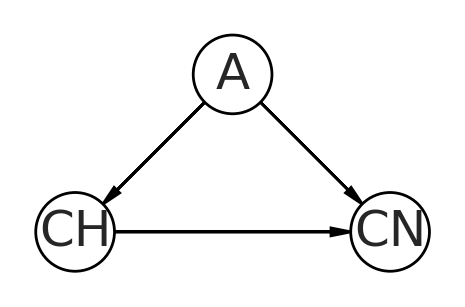

<IPython.core.display.Javascript object>

In [21]:
pipe_dag = CausalGraphicalModel(
    nodes=["CH", "A", "CN"],
    edges=[
        ("A", "CH"),
        ("A", "CN"),
        ("CH", "CN"),
    ],
)
pgm = daft.PGM()

coordinates = {
    "CH": (0, 0),
    "A": (1, 1),
    "CN": (2, 0),
}
for node in pipe_dag.dag.nodes:
    pgm.add_node(node, node, *coordinates[node])
for edge in pipe_dag.dag.edges:
    pgm.add_edge(*edge)
pgm.render()

Need to add `urban` and `district`.

Use a model with urban and district.

Then use a model with children and a model without children.

There's a masked association thing going on when seeing the coefficients with the two models.

# 14H4

Varying effects models are useful for modeling timeseries, as well as spatial clusteirng. In a timeseries, the observations cluster by entitites that have continuity through time, such as individuals. Since observations within individuals are likely highly correlated, the multilevel structure can help quite a lot. You'll use the data in `data(Oxboys)`, which is 234 height measurements on 26 boys from an Oxford Boys Club, at 9 different ages (centered and standardized) per boy. You'll be interested in predicting height, using age, clustered by Subject
(individual boy). Fit a model with varying intercepts and slopes (on age), clustered by Subject. Present and interpret the parameter estimates Which varying effect contributes more variation to the heights, the intercept or the slope?

- model time series
- cluster by individuals
- predict height, using age, cluster by subject

In [6]:
df_oxboys = pd.read_csv(
    "../pymc3_ed_resources/resources/Rethinking/Data/oxboys.csv",
    delimiter=";",
)

,Subject,age,height,Occasion
0,1,-1.0000,140.5,1
1,1,-0.7479,143.4,2
2,1,-0.4630,144.8,3
3,1,-0.1643,147.1,4
4,1,-0.0027,147.7,5


<IPython.core.display.Javascript object>

In [19]:
df_oxboys['height_std'] = standardize(df_oxboys['height'])

<IPython.core.display.Javascript object>

In [20]:
df_oxboys['Subject_code'] = pd.Categorical(df_oxboys['Subject']).codes
df_oxboys[['Subject', 'Subject_code']].drop_duplicates().head()

,Subject,Subject_code
0,1,0
9,2,1
18,3,2
27,4,3
36,5,4


<IPython.core.display.Javascript object>

In [21]:
df_oxboys.head()

,Subject,age,height,Occasion,Subject_code,height_std
0,1,-1.0000,140.5,1,0,-0.992917
1,1,-0.7479,143.4,2,0,-0.673666
2,1,-0.4630,144.8,3,0,-0.519544
3,1,-0.1643,147.1,4,0,-0.266344
4,1,-0.0027,147.7,5,0,-0.200292


<IPython.core.display.Javascript object>

## First attempt (thought it was a Gaussian process problem)

$$ h \sim \text{Normal}(\mu, \sigma)$$

$$ \mu = k_\text{IND} + \beta_\text{IND}\text{AGE}$$

$$ k \sim \text{Normal}(\bar{\alpha}, \sigma) $$

$$ \begin{pmatrix} k_1  \\ k_2 \\ k_3 \\ ... \\ k_{26} \end{pmatrix} \sim \text{MVNormal} \begin{pmatrix} \begin{pmatrix} 0  \\ 0 \\ 0 \\ ... \\ 0  \end{pmatrix}, \text{K} \end{pmatrix} \tag{prior for intercepts}$$ 

$$ \text{K}_{ij} = \eta^2 \exp{(-\rho^2D^2_{ij}}) + \delta_{ij}\sigma^2 \tag{covariance matrix}$$

$$ \eta^2 \sim \text{Exponential}(2)   \tag{hyperprior}$$

$$ \rho^2 \sim \text{Exponential}(0.5)   \tag{hyperprior}$$

$$ \sigma^2 \sim \text{Exponential}(2)   \tag{hyperprior}$$

We use exponential priors since $\eta^2$ and $\rho^2$ must be positive.

The first three lines should be straightforward. Our likelihood function is Normal with two parameters mean and sigma. The linear function is on the second line. We're using $k$ as the intercept term and we will have 26 of these, one for each boy. The coefficient on age (for each boy) will tell us how much age influences our prediction on height.

Not sure if I need the third line yet.

The prior for intercepts is our 26-dimensional Gaussian prior for intercepts. Again each dimension represents a boy. The vector of means is all zeros, which makes sense since we'd expect to have some average age.

Then we have the covariance matrix in the last line. This is meant to show a link between similar ages.

- $\exp{(-\rho^2D^2_{ij}})$ : gives the covariance model shape. D is the distance in age between the i-th and j-th boy. It just means that the covariance between two boys will decline exponentially with the squared distance in age between them. The parameter $\rho$ is not the correlation (CONFUSING!) it is the parameter that determines the rate of decline. If it's large, then covariance will decline rapidly.
 - $\eta^2$ : the maximum covariance between any two boys, i and j (when i != j).
 - $\delta_{ij}\sigma^2$ : provides for extra covariance beyond $\eta^2$ when i = j. This term becomes 1 when i = j, but 0 otherwise. If we had only one observation, the $\sigma$ term wouldn't matter, but in this problem, we have multiple observations per boy so it will matter.

In [7]:
df_oxboys.head()

,Subject,age,height,Occasion
0,1,-1.0000,140.5,1
1,1,-0.7479,143.4,2
2,1,-0.4630,144.8,3
3,1,-0.1643,147.1,4
4,1,-0.0027,147.7,5


<IPython.core.display.Javascript object>

In [ ]:
with pm.Model() as m14h4_a:
    
    # intercept and slope
    a = pm.Normal("a", 0, 1)
    b = pm.Normal("b", 0, 1)

    # Hyperpriors for Gaussian prior, taken from repo (not sure how to enter different values)
    etasq = pm.Exponential("etasq", 2.0)
    ls_inv = pm.HalfNormal("ls_inv", 2.0)
    rhosq = pm.Deterministic("rhosq", 0.5 * ls_inv ** 2)
    sigmasq = pm.Exponential("sigmasq", 2.0)

    # Implementation with PyMC's GP module:
    cov = etasq * pm.gp.cov.ExpQuad(input_dim=1, ls_inv=ls_inv)
    gp = pm.gp.Latent(cov_func=cov)
    k = gp.prior("k", X=Dmat)

    # link function
    mu = a[df_oxboys['subject']] + b[df_oxboys['subject']] * df_oxboys['age']

    # likelihood since each represents an individual woman
    h = pm.Normal("h", mu, sigma, observed=df_oxboys["height"])

    trace_m14h4_a = pm.sample(draws=1000, return_inferencedata=True)

Realized this was going down the wrong path.

## Second attempt (simpler varying slope/intercept problem)

$$ h \sim \text{Normal}(\mu, \sigma)$$

$$ \mu = \alpha_\text{IND} + \beta_\text{IND}\text{AGE}$$

$$ \alpha \sim \text{Normal}(\bar{\alpha}, \sigma) $$
$$ \beta \sim \text{Normal}(\bar{\beta}, \sigma) $$

$$\begin{bmatrix}\alpha_{\text{district}} \\ \beta_{\text{district}} \end{bmatrix} \sim \text {MVNormal } \left( \begin{bmatrix}\alpha \\ \beta \end{bmatrix} , \text{S} \right)  \tag{population of varying effects} $$

$$ \text{S} = \begin{pmatrix} \sigma_{\alpha} & 0 \\ 0 & \sigma_{\beta} \end{pmatrix} \text{R} \begin{pmatrix} \sigma_{\alpha} & 0 \\ 0 & \sigma_{\beta} \end{pmatrix}  $$

$$ \alpha \sim \text{Normal}(0, 1) \tag{prior for average intercept} $$
$$ \beta \sim \text{Normal}(0, 1)  \tag{prior for average slope} $$

$$ \sigma_{alpha} \sim \text{Exponential}(1) \tag{prior sddev among intercepts} $$
$$ \sigma_{beta} \sim \text{Exponential}(1) \tag{prior sddev among slopes} $$
$$ \sigma \sim \text{Exponential}(1) \tag{prior for likelihood} $$

$$ \text{R} \sim \text{LKJcorr}(2) \tag{prior for correlation matrix} $$

,Subject,Subject_code
0,1,0
9,2,1
18,3,2
27,4,3
36,5,4


<IPython.core.display.Javascript object>

In [24]:
n_boys = len(df_oxboys['Subject'].unique())

with pm.Model() as m14h4_b:
    # LKJCholeskyCov is more efficient than LKJCorr
    # PyMC >= 3.9 extracts the stds and matrix of correlations automatically for us
    # Don't know where sigma_subject goes
    chol, Rho_, sigma_subject = pm.LKJCholeskyCov(
        "chol_cov", n=2, eta=2, sd_dist=pm.Exponential.dist(1.0), compute_corr=True
    )

    # Not sure if I need these
    # a_bar = pm.Normal("a_bar", mu=0, sd=1)
    # b_bar = pm.Normal("b_bar", mu=0, sd=1)

    sigma_a = pm.Exponential("sigma_a", 1)
    sigma_b = pm.Exponential("sigma_b", 1)
    sigma = pm.Exponential("sigma", 1)

    a = pm.Normal("a", mu=0, sd=1)
    b = pm.Normal("b", mu=0, sd=1)

    ab_subject = pm.MvNormal(
        "ab_subject", mu=tt.stack([a, b]), chol=chol, shape=(n_boys, 2)
    )

    # linear model
    mu = (ab_subject[df_oxboys["Subject_code"], 0]
            + ab_subject[df_oxboys["Subject_code"], 1] * df_oxboys['age']
        )

    # likelihood, n=1 since each represents an individual woman
    h = pm.Normal("h", mu, sigma, observed=df_oxboys["height_std"])

    trace_m14h4_b = pm.sample(draws=1000, random_seed=19, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ab_subject, b, a, sigma, sigma_b, sigma_a, chol_cov]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 50 seconds.


<IPython.core.display.Javascript object>

In [26]:
az.summary(trace_m14h4_b, var_names=['a', 'b', 'ab_subject'])

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,-0.021,0.184,-0.326,0.259,0.003,0.003,3561.0,2356.0,3581.0,2975.0,1.00
b,0.718,0.040,0.655,0.782,0.001,0.001,3220.0,3217.0,3233.0,2396.0,1.00
"ab_subject[0,0]",-0.153,0.024,-0.191,-0.114,0.000,0.000,7710.0,7682.0,7695.0,2890.0,1.00
"ab_subject[0,1]",0.785,0.036,0.732,0.844,0.000,0.000,6672.0,6647.0,6675.0,3032.0,1.00
"ab_subject[1,0]",-0.733,0.024,-0.771,-0.693,0.000,0.000,5605.0,5556.0,5626.0,2763.0,1.00
"ab_subject[1,1]",0.601,0.037,0.539,0.657,0.000,0.000,5702.0,5615.0,5752.0,2436.0,1.00
"ab_subject[2,0]",0.674,0.024,0.636,0.714,0.000,0.000,6474.0,6458.0,6460.0,3120.0,1.00
"ab_subject[2,1]",0.542,0.038,0.484,0.603,0.000,0.000,6041.0,5945.0,6055.0,2861.0,1.00
"ab_subject[3,0]",1.711,0.025,1.673,1.752,0.000,0.000,7319.0,7302.0,7332.0,2753.0,1.00
"ab_subject[3,1]",1.024,0.036,0.965,1.081,0.000,0.000,5402.0,5402.0,5409.0,2603.0,1.00


<IPython.core.display.Javascript object>

In [27]:
# Let's turn it into a dataframe for plotting
df_ab_subject = az.summary(trace_m14h4_b, var_names="ab_subject")
df_ab_subject.head()

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
"ab_subject[0,0]",-0.153,0.024,-0.191,-0.114,0.0,0.0,7710.0,7682.0,7695.0,2890.0,1.0
"ab_subject[0,1]",0.785,0.036,0.732,0.844,0.0,0.0,6672.0,6647.0,6675.0,3032.0,1.0
"ab_subject[1,0]",-0.733,0.024,-0.771,-0.693,0.0,0.0,5605.0,5556.0,5626.0,2763.0,1.0
"ab_subject[1,1]",0.601,0.037,0.539,0.657,0.0,0.0,5702.0,5615.0,5752.0,2436.0,1.0
"ab_subject[2,0]",0.674,0.024,0.636,0.714,0.0,0.0,6474.0,6458.0,6460.0,3120.0,1.0


<IPython.core.display.Javascript object>

[Text(0.5, 0, 'intercepts (a_subject)'),
 Text(0, 0.5, 'slopes (b_subject)'),
 Text(0.5, 1.0, 'intercepts vs. slopes\n(subjects)')]

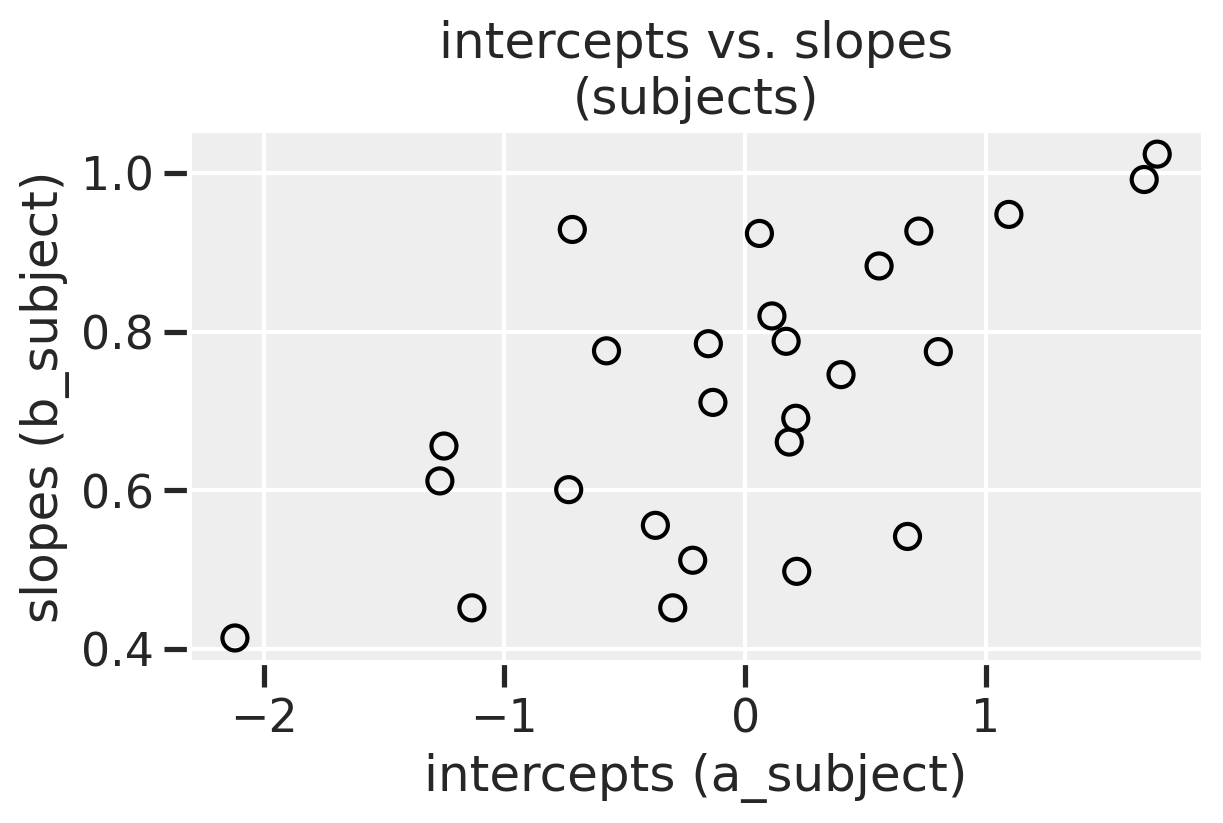

<IPython.core.display.Javascript object>

In [30]:
# Can add concentric circles later
f, ax1 = plt.subplots(1, 1, figsize=(6, 4))
for i in range(n_boys):
    ax1.scatter(
        df_ab_subject.loc["ab_subject[" + str(i) + ",0]", "mean"],
        df_ab_subject.loc["ab_subject[" + str(i) + ",1]", "mean"],
        facecolors="none",
        edgecolors="black",
    )

ax1.set(
    xlabel="intercepts (a_subject)",
    ylabel="slopes (b_subject)",
    title="intercepts vs. slopes\n(subjects)",
)

I would say that the intercepts contribute more variation since there is a bigger spread than the slope (intercepts range from -2 to almost 2). We can compare them since the height for each subject (intercept) and the age (slope) are standardized.

Plotting the raw data as line plots.

In [34]:
df_oxboys.head()

,Subject,age,height,Occasion,Subject_code,height_std
0,1,-1.0000,140.5,1,0,-0.992917
1,1,-0.7479,143.4,2,0,-0.673666
2,1,-0.4630,144.8,3,0,-0.519544
3,1,-0.1643,147.1,4,0,-0.266344
4,1,-0.0027,147.7,5,0,-0.200292


<IPython.core.display.Javascript object>

[Text(0.5, 0, 'age'),
 Text(0, 0.5, 'std height'),
 Text(0.5, 1.0, 'Height trajectory per subject\n(raw data)')]

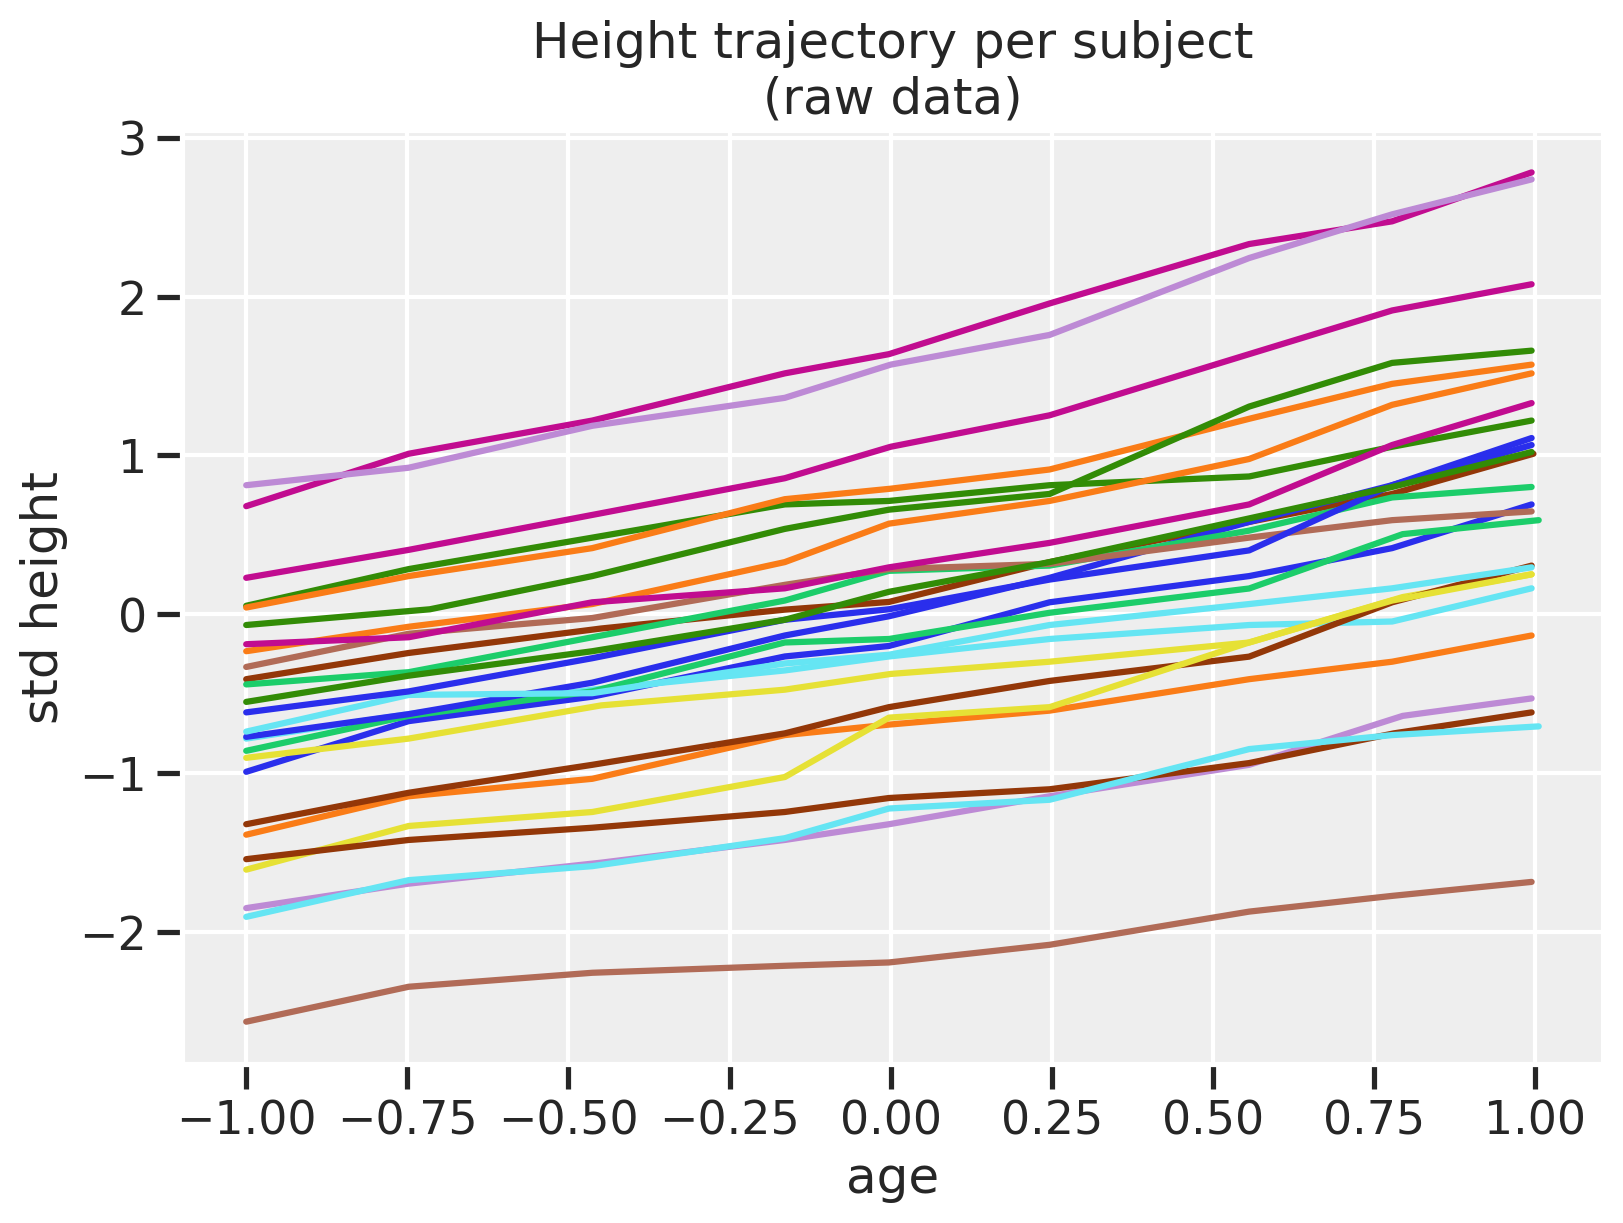

<IPython.core.display.Javascript object>

In [37]:
f, ax1 = plt.subplots(figsize=(8, 6))
for boy in range(n_boys):
    df_oxboys_subject = df_oxboys[df_oxboys['Subject_code']==boy]
    ax1.plot(df_oxboys_subject["age"], df_oxboys_subject["height_std"])

ax1.set(xlabel='age', ylabel='std height', title='Height trajectory per subject\n(raw data)')

# 14H5

Now consider the correlation between the varying intercepts and slopes. Can you explain its value? How would this estimated correlation influence your predictions about a new sample of boys?

In [33]:
az.summary(trace_m14h4_b, var_names='chol_cov_corr')

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/stats/diagnostics.py:642: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
"chol_cov_corr[0,0]",1.000,0.000,1.000,1.000,0.000,0.000,4000.0,4000.0,4000.0,4000.0,NaN
"chol_cov_corr[0,1]",0.561,0.138,0.362,0.787,0.002,0.002,4143.0,4143.0,4274.0,3195.0,1.0
"chol_cov_corr[1,0]",0.561,0.138,0.362,0.787,0.002,0.002,4143.0,4143.0,4274.0,3195.0,1.0
"chol_cov_corr[1,1]",1.000,0.000,1.000,1.000,0.000,0.000,4000.0,4000.0,4118.0,3824.0,1.0


<IPython.core.display.Javascript object>

The correlation between intercepts and slopes is ~0.561 which means there's a relationship between a boy's average height and how much they might be able to gain with age. A boy that is taller can actually gain more in height with age, than a shorter boy.

Appendix: Environment and system parameters

In [33]:
%watermark -n -u -v -iv -w

Last updated: Fri Jul 02 2021

Python implementation: CPython
Python version       : 3.8.6
IPython version      : 7.20.0

pandas    : 1.2.1
matplotlib: 3.3.4
arviz     : 0.11.1
pymc3     : 3.11.0
daft      : 0.1.0
json      : 2.0.9
numpy     : 1.20.1
seaborn   : 0.11.1
scipy     : 1.6.0

Watermark: 2.1.0



<IPython.core.display.Javascript object>